In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pds
import networkx as nx
import re
import pandas as pd

In [4]:
import re
s = '111()))()()'
print(re.sub(u"([^\()])","",s))

()))()()


In [5]:
sp_id_list = []
with open('../input/G_info.txt') as f:
    for line in f:
        sp_id_list.append(line.split("\t")[0])
len(sp_id_list)

162

In [6]:
with open('cvtree.newick') as f:
    cv_nwk = f.readline()
cv_nwk

'(((((((((((((((2678:0.17,2673:0.17):0.03,(2693:0.17,2659:0.17):0.03):0.01,(2711:0.18,2681:0.18):0.02):0.03,(((2719:0.01,2712:0.01):0.11,2708:0.13):0.07,2653:0.20):0.04):0.01,((((((1234:0.01,1220:0.01):0.00,1247:0.01):0.01,1284:0.02):0.02,(((1289:0.01,1276:0.01):0.00,1256:0.01):0.01,1265:0.02):0.02):0.16,(2705:0.01,2704:0.01):0.19):0.02,2721:0.22):0.02):0.00,2714:0.24):0.01,(((1508:0.02,1502:0.02):0.19,2723:0.21):0.03,((2923:0.14,2733:0.14):0.01,((1521:0.01,1520:0.01):0.01,(1535:0.01,1534:0.01):0.01):0.12):0.09):0.02):0.01,((((((((2827:0.10,2822:0.10):0.03,2820:0.13):0.01,(2935:0.04,2931:0.04):0.10):0.02,2667:0.16):0.03,951:0.19):0.03,(((((1542:0.00,1536:0.00):0.00,1545:0.01):0.00,1546:0.01):0.01,(1533:0.01,1522:0.01):0.01):0.12,2692:0.14):0.07):0.01,(((2682:0.04,1541:0.04):0.10,2829:0.14):0.06,((((2672:0.06,2671:0.06):0.03,2836:0.09):0.01,1572:0.10):0.01,(2830:0.09,955:0.09):0.02):0.10):0.02):0.03,(((((2817:0.10,1511:0.10):0.02,(2722:0.10,1518:0.10):0.03):0.09,2662:0.21):0.01,((((1540

In [12]:
def count_dist(string):
    h = 0
    tmp = 0
    for i in string:
        if i == '(':
            tmp += 1
        if i == ')':
            if tmp == 0:
                h += 1
            else:
                tmp -= 1
    return h + tmp

In [13]:
def tree_dist(nwk_file, sp_id_list=sp_id_list):
    with open(nwk_file) as f:
        nwk_s = f.readline()
    
    dist_dict = {}
    for i in range(len(sp_id_list)):
        for j in range(i, len(sp_id_list)):
            if i != j:
                if nwk_s.index(sp_id_list[i])<nwk_s.index(sp_id_list[j]):
                    a, b = sp_id_list[i],sp_id_list[j]
                else:
                    a, b = sp_id_list[j],sp_id_list[i]
                x = nwk_s.split(a+':')[1].split(b+':')[0]
                x_cut = re.sub(u"([^\()])","",x)
                dist = count_dist(x_cut)
            else:
                a= b = sp_id_list[i]
                dist = 0
            if a not in dist_dict:
                dist_dict[a] = {}
            dist_dict[a][b] = dist
    return dist_dict

In [14]:
def dist_diff(dist_dict_1, dist_dict_2, title):
    dist_diff_dict = {}
    for node_a, node_b_dist in dist_dict_1.items():
        if len(node_b_dist) == 0:
            continue
        dist_diff_dict[node_a] = {}   
        for node_b in node_b_dist.keys():
            if node_b in dist_dict_2[node_a]:
                dist_diff_dict[node_a][node_b] = abs(dist_dict_1[node_a][node_b] - dist_dict_2[node_a][node_b])
            else:
                dist_diff_dict[node_a][node_b] = abs(dist_dict_1[node_a][node_b] - dist_dict_2[node_b][node_a])
    for node_a, node_b_l in dist_diff_dict.items():
        for node_b in node_b_l:
            dist_diff_dict[node_b][node_a] = dist_diff_dict[node_a][node_b]
            
    dist_diff_df = pd.DataFrame.from_dict(dist_diff_dict)
    order = dist_diff_df.index.tolist()
    dist_diff_df =  dist_diff_df[order]
    
    plt.figure(figsize=(50, 50))
    sns.heatmap(data=dist_diff_df,cmap="YlGnBu_r", square=True)
    plt.title(title,fontsize= 25)
    return dist_diff_dict

In [15]:
def diff_stat(dist_diff_dict):
    total_over = 0
    total_dist = 0
    for node_1, dist_dict in dist_diff_dict.items():
        for node_2 in dist_dict.keys():
            if node_1 != node_2:
                total_dist += dist_dict[node_2]
                if dist_dict[node_2] == 0:
                    total_over += 1
    total_dist = total_dist/2
    total_over = total_over/2
    print(total_over, total_dist)

In [16]:
def adj_structure(dist_diff_dict):
    
    dist_cv_co_edge = []
    for node_a, node_b_dist in dist_diff_dict.items():
        for node_b, dist in node_b_dist.items():
            if (node_a != node_b) and (dist == 0):
                dist_cv_co_edge.append([node_a, node_b])    
                
    ## 仅选双向的
    dist_cv_co_edge_ex = []
    for edge_1 in range(len(dist_cv_co_edge)):
        for edge_2 in range(edge_1+1, len(dist_cv_co_edge)):
            edge_a = dist_cv_co_edge[edge_1]
            edge_b = dist_cv_co_edge[edge_2]
            if (edge_a[0] in edge_b) and (([edge_a[1], edge_b[0]] in dist_cv_co_edge) or  ([edge_b[0], edge_a[1]] in dist_cv_co_edge)) and\
            (([edge_a[1], edge_b[1]] in dist_cv_co_edge) or  ([edge_b[1], edge_a[1]] in dist_cv_co_edge)):
                dist_cv_co_edge_ex.append(edge_a)
                dist_cv_co_edge_ex.append(edge_b)
        
    
    G = nx.Graph()
    G.add_edges_from(dist_cv_co_edge_ex)

    connected_node = list()
    for c in nx.connected_components(G):
        nodeSet = G.subgraph(c).nodes()
        connected_node.append(nodeSet)
        
    plt.figure(figsize=(10, 10))
    node_color = [G.degree(v) for v in G.nodes()]
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color = 'black', with_labels = False, edge_color = 'grey', width = 0.3, 
            node_size = 2)
    plt.show()
    
    return [len(i) for i in connected_node], len(connected_node)

In [31]:
dist_cv_dict = tree_dist('cvtree.newick')
dist_A1T7_dict = tree_dist('sp_C_matrix_t82_re_qf_b_AGE_100_tra_07.netwick')
dist_A1T1_dict = tree_dist('sp_C_matrix_t82_re_qf_b_AGE_100_tra.netwick')
dist_A2T7_dict = tree_dist('sp_C_matrix_t82_re_qf_b_AGE_200_tra_07.netwick')
dist_A2T1_dict = tree_dist('sp_C_matrix_t82_re_qf_b_AGE_200_tra.netwick')
dist_A1_dict = tree_dist('sp_C_matrix_t82_re_qf_b_cut_100.netwick')
dist_A2_dict = tree_dist('sp_C_matrix_t82_re_qf_b_cut_200.netwick')
dist_tra_dict = tree_dist('sp_C_matrix_t82_re_qf_b_cut_tra.netwick')
dist_TA1_dict = tree_dist('sp_C_matrix_t82_re_qf_b_tra_AGE_100.netwick')
dist_TA2_dict = tree_dist('sp_C_matrix_t82_re_qf_b_tra_AGE_200.netwick')

510.0 88315.0


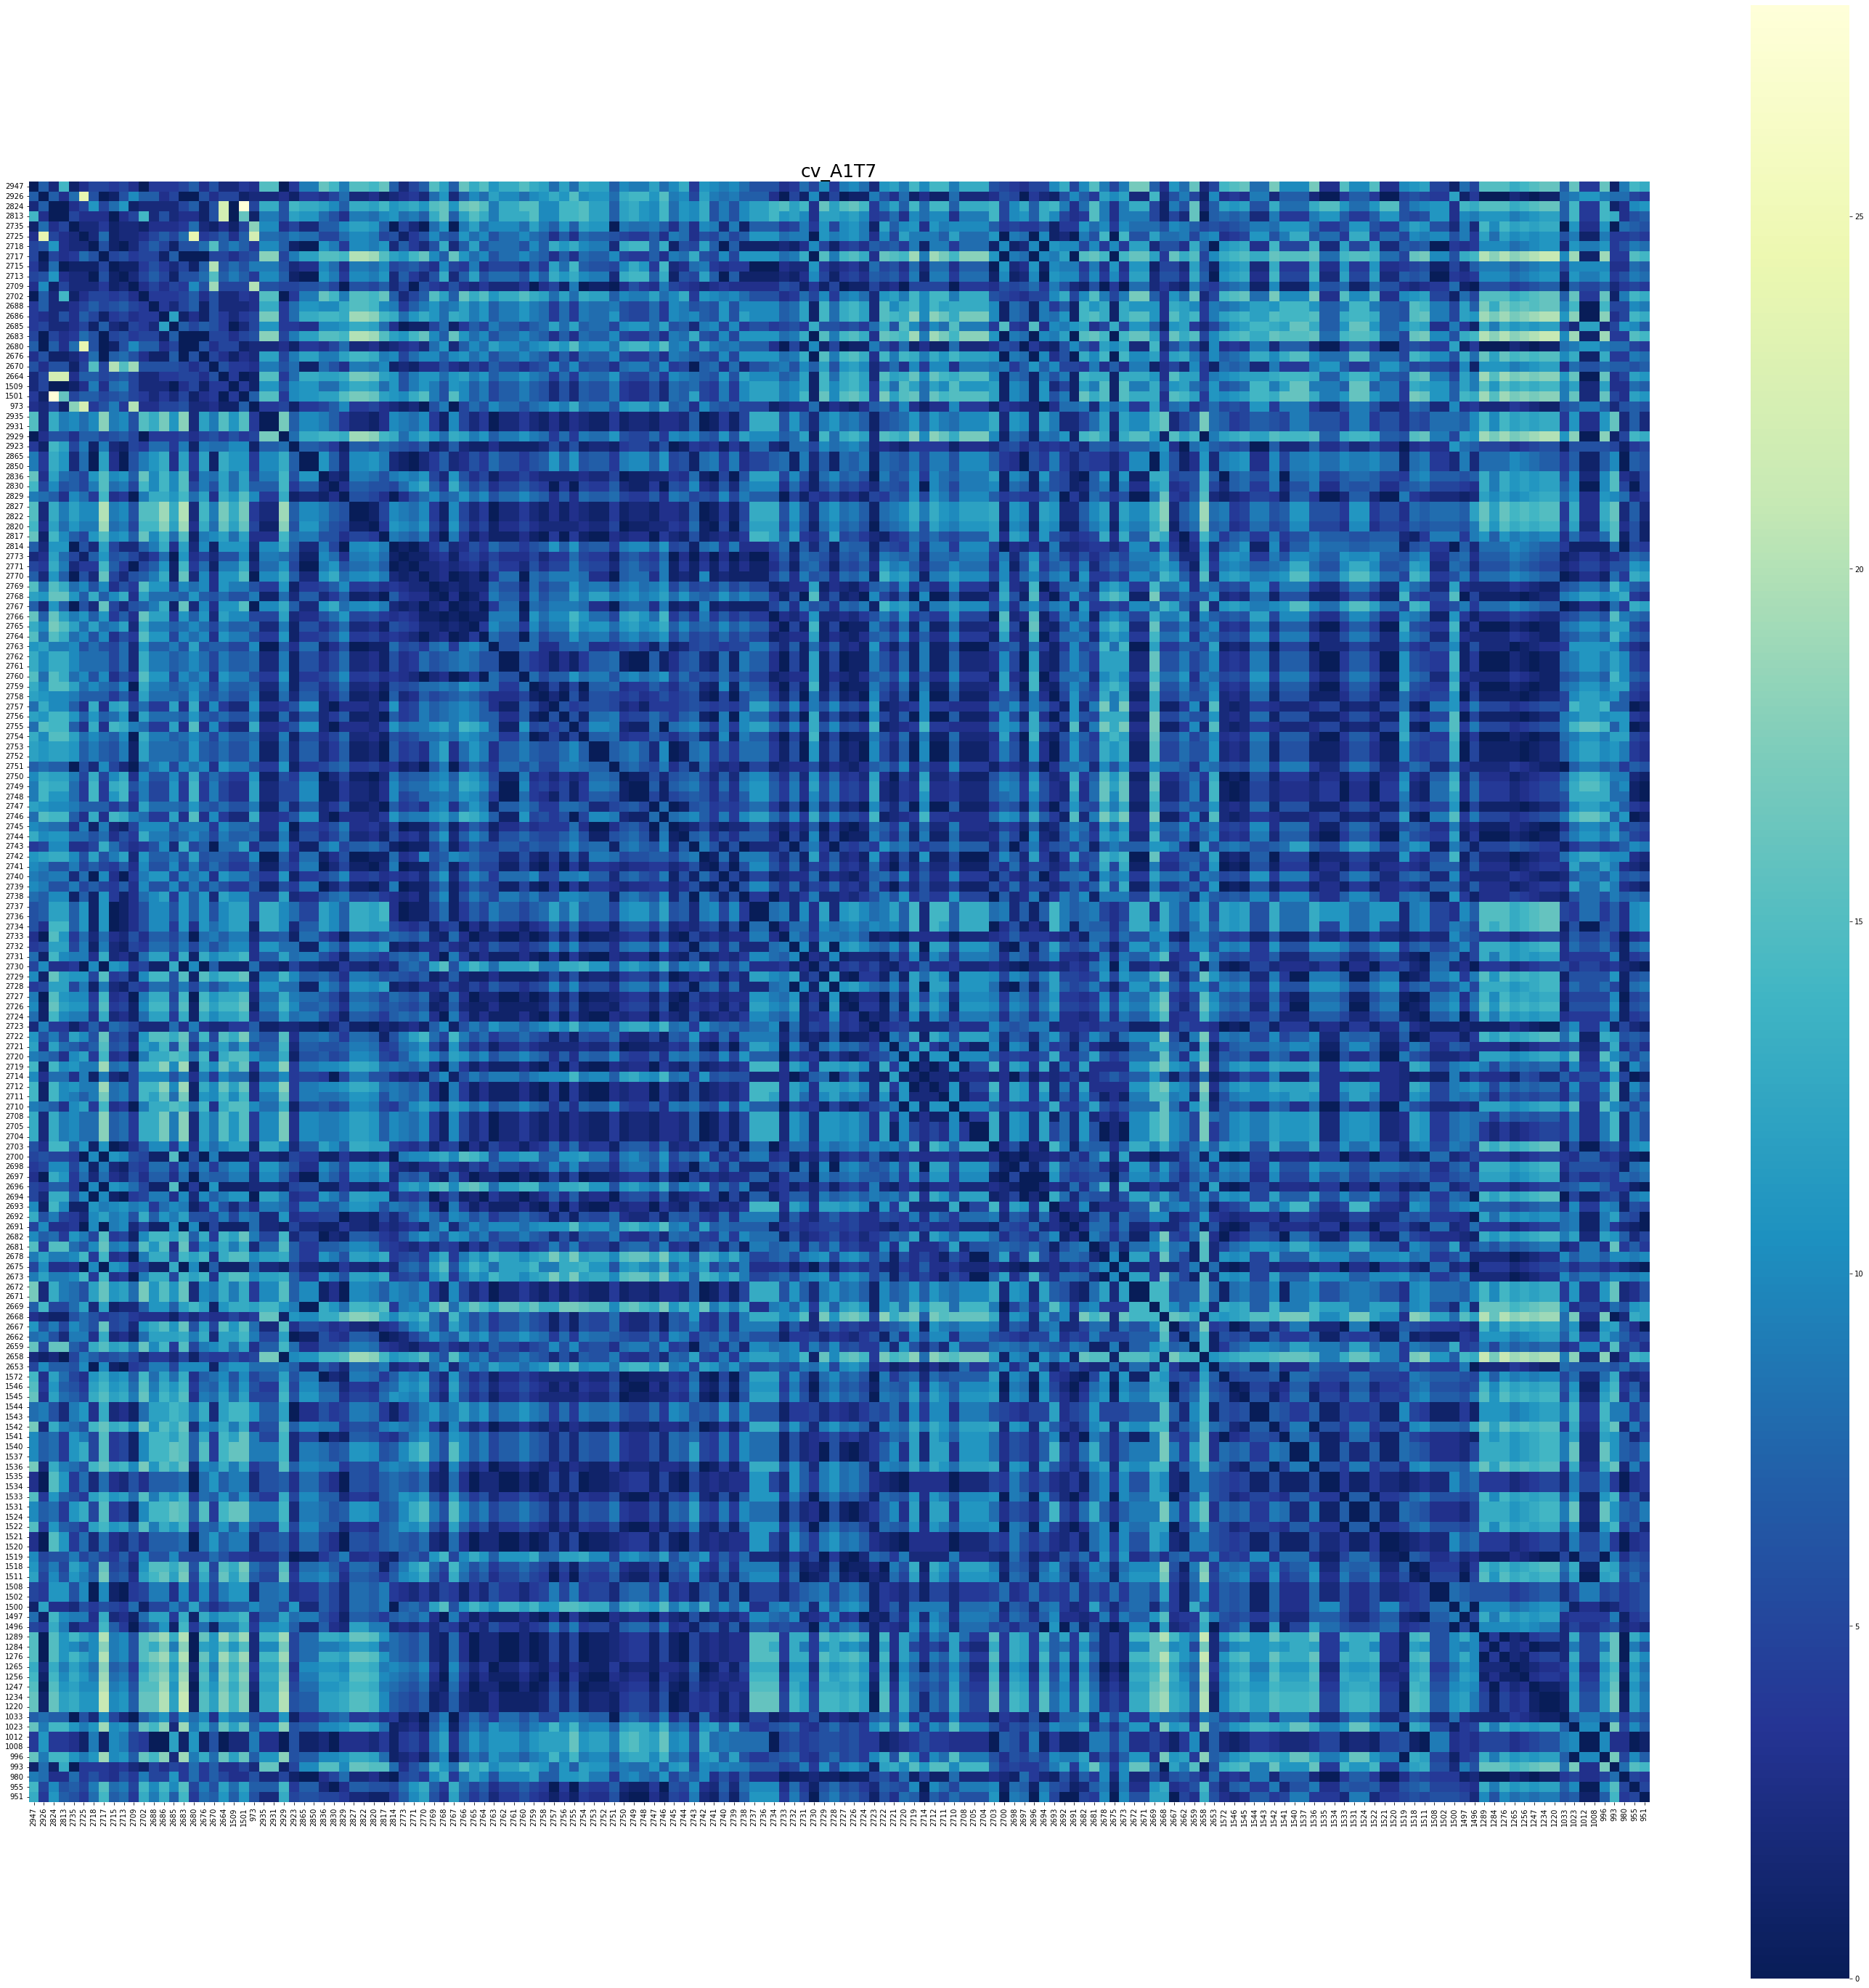

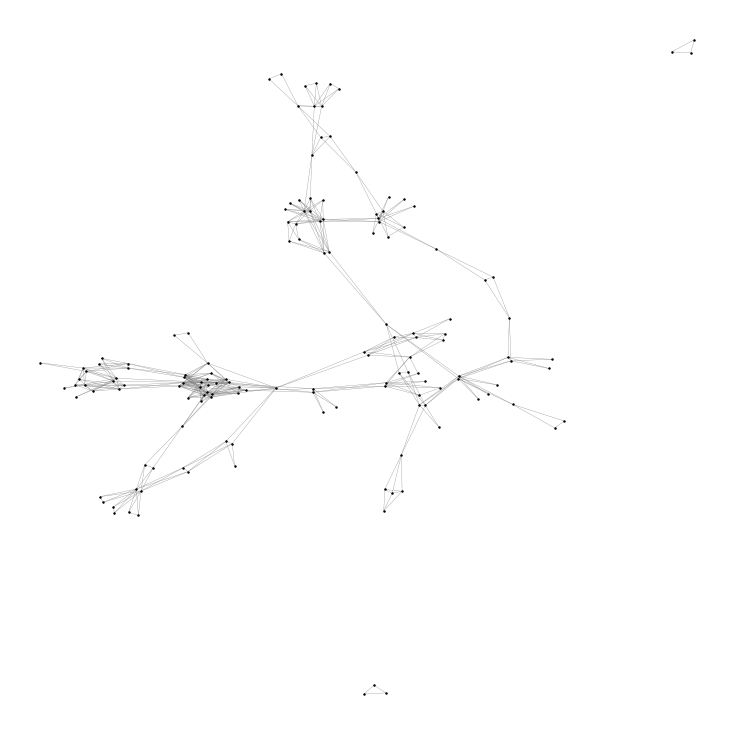

([65, 77, 3, 3], 4)

In [48]:
dist_A1T7_diff_dict = dist_diff(dist_cv_dict, dist_A1T7_dict, 'cv_A1T7')
diff_stat(dist_A1T7_diff_dict)
adj_structure(dist_A1T7_diff_dict)

723.0 148346.0


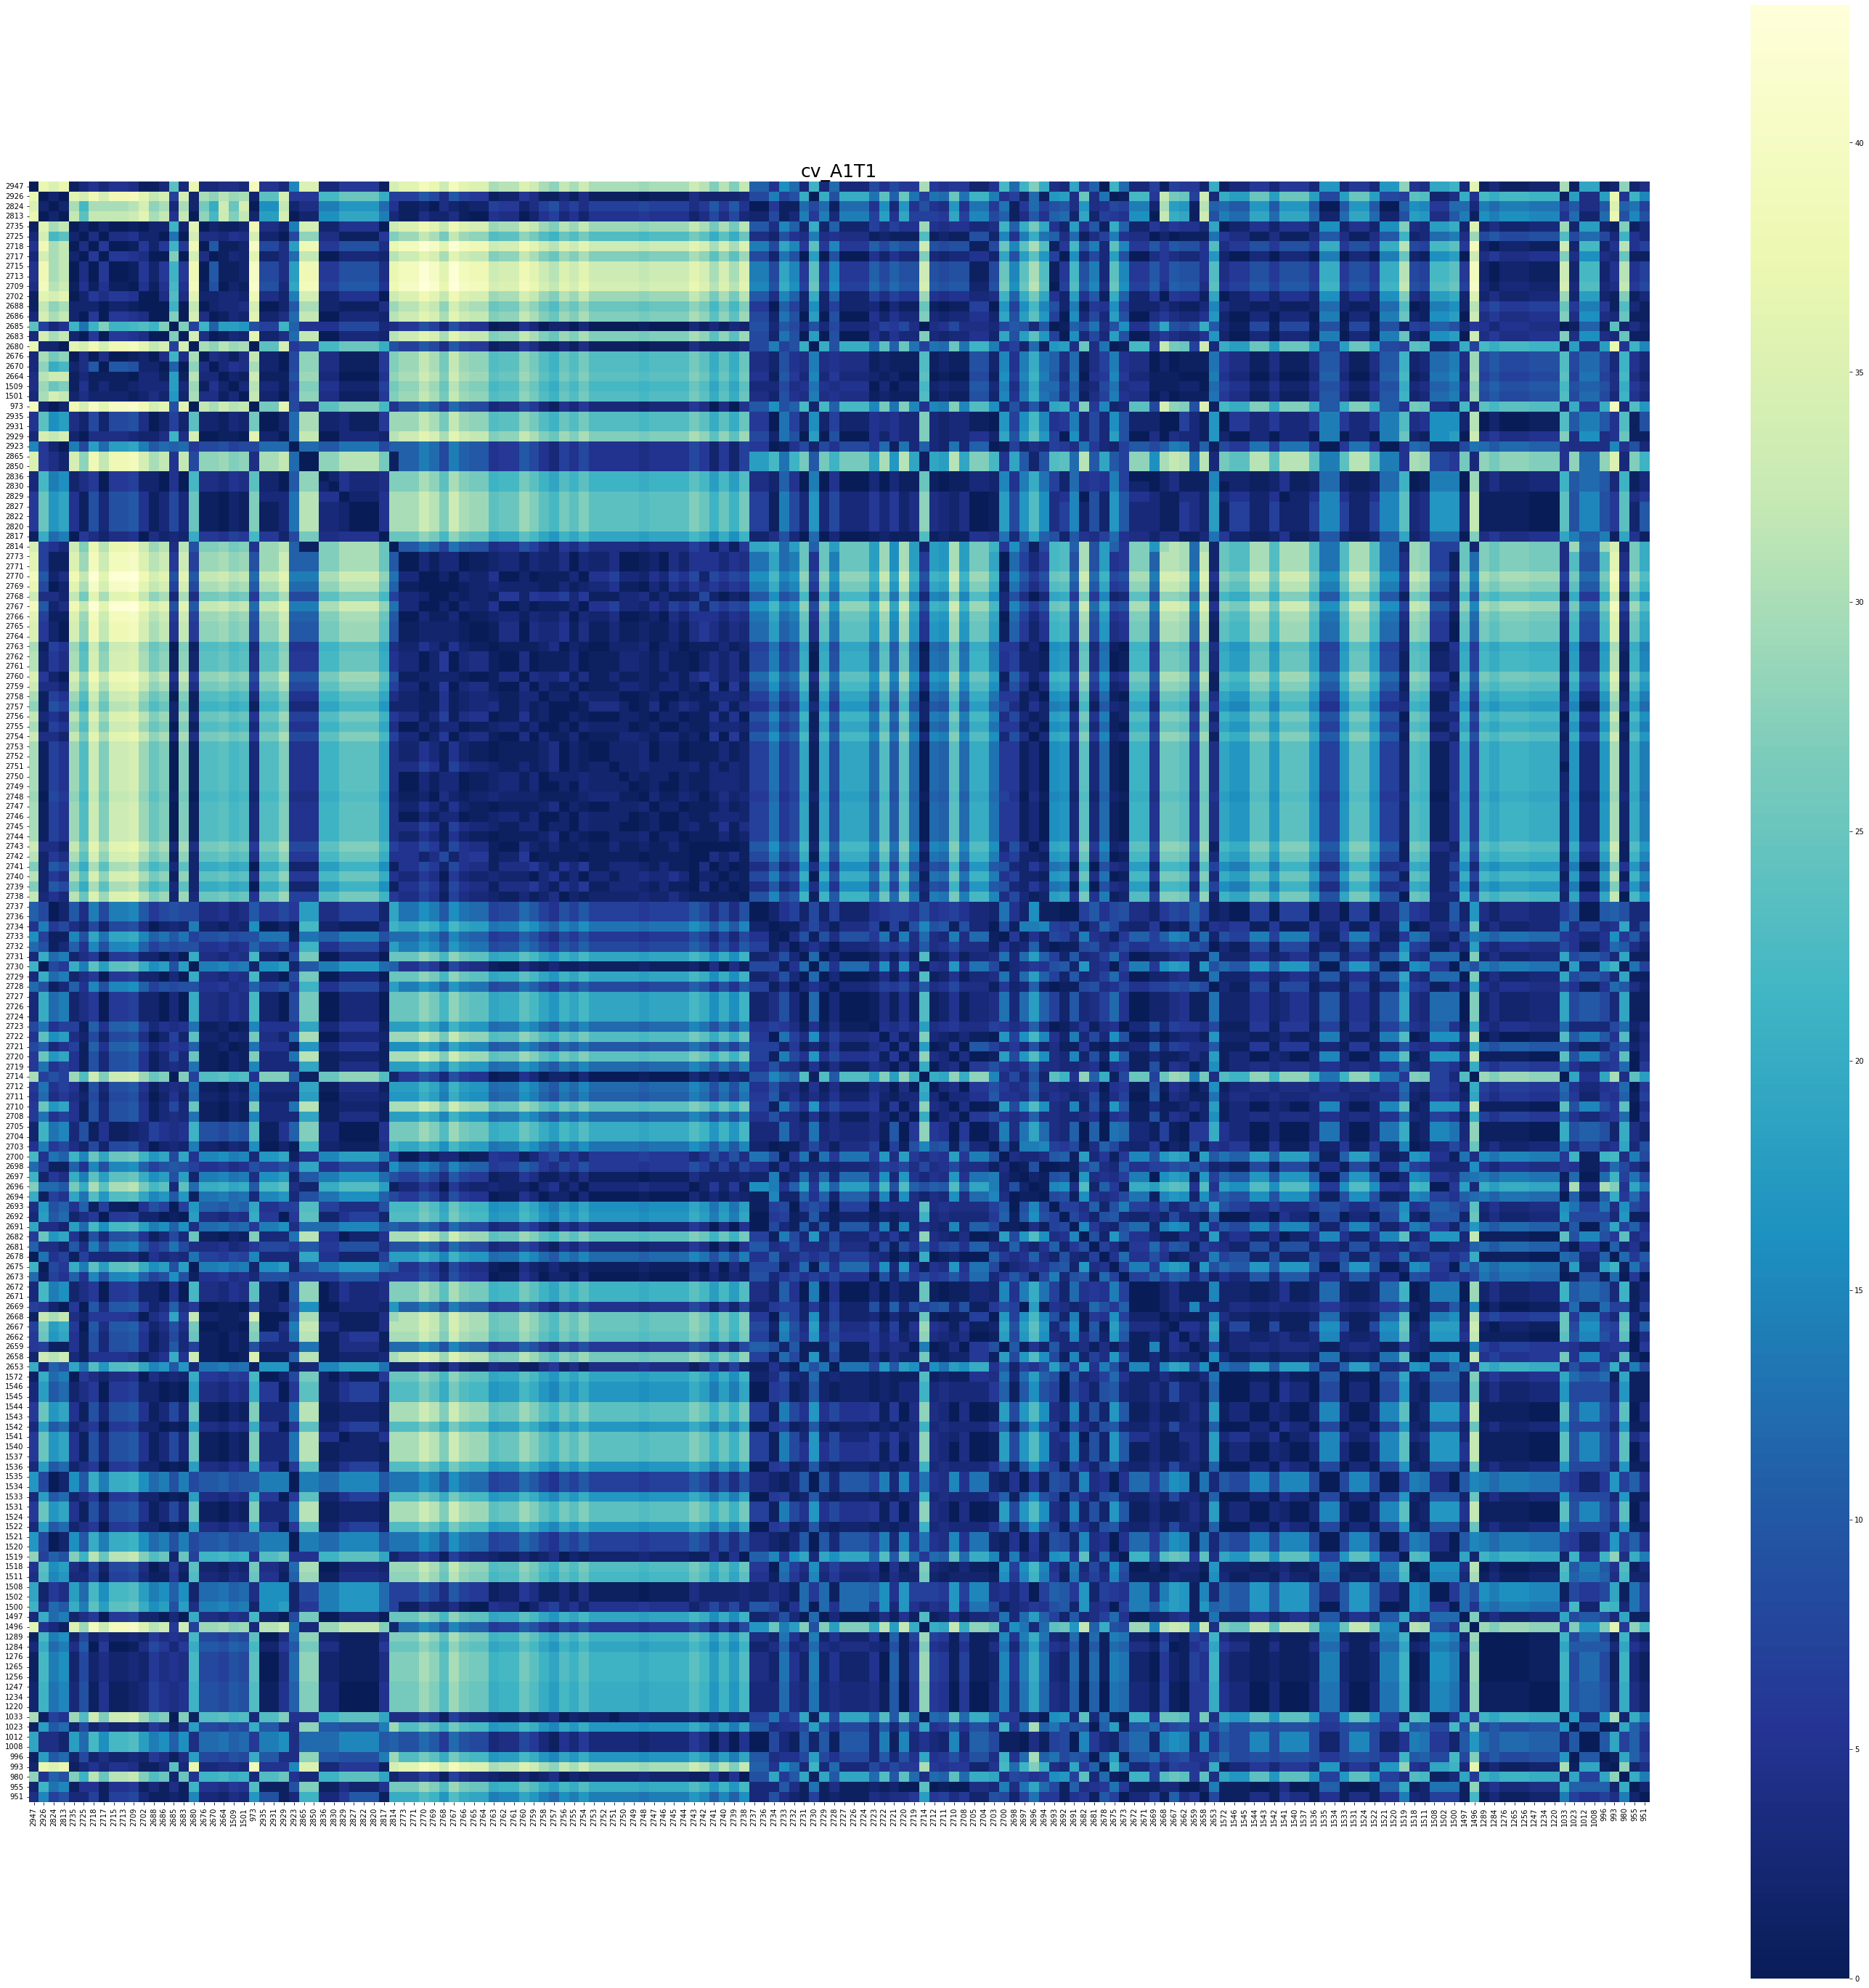

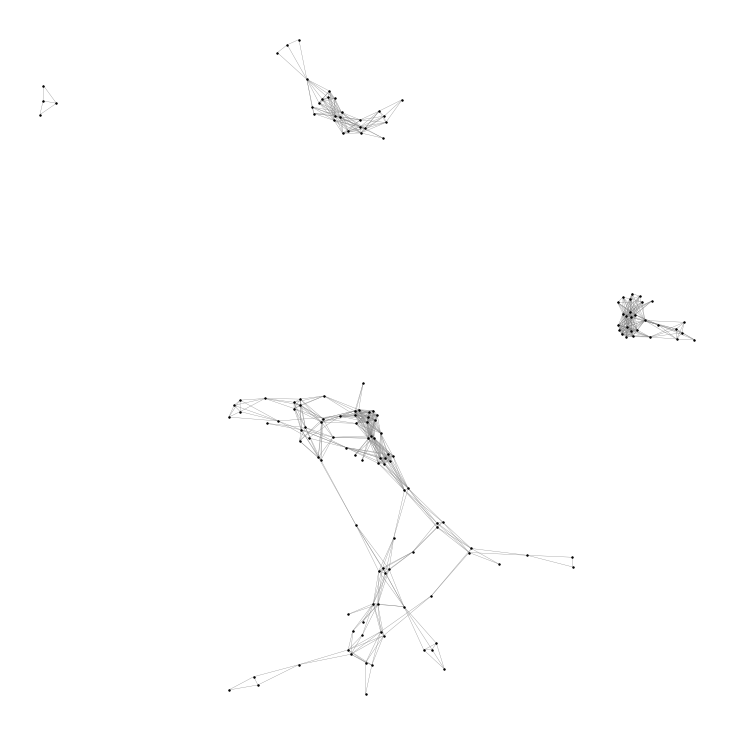

([88, 28, 26, 4], 4)

In [37]:
dist_A1T1_diff_dict = dist_diff(dist_cv_dict, dist_A1T1_dict, 'cv_A1T1')
diff_stat(dist_A1T1_diff_dict)
adj_structure(dist_A1T1_diff_dict)

648.0 147178.0


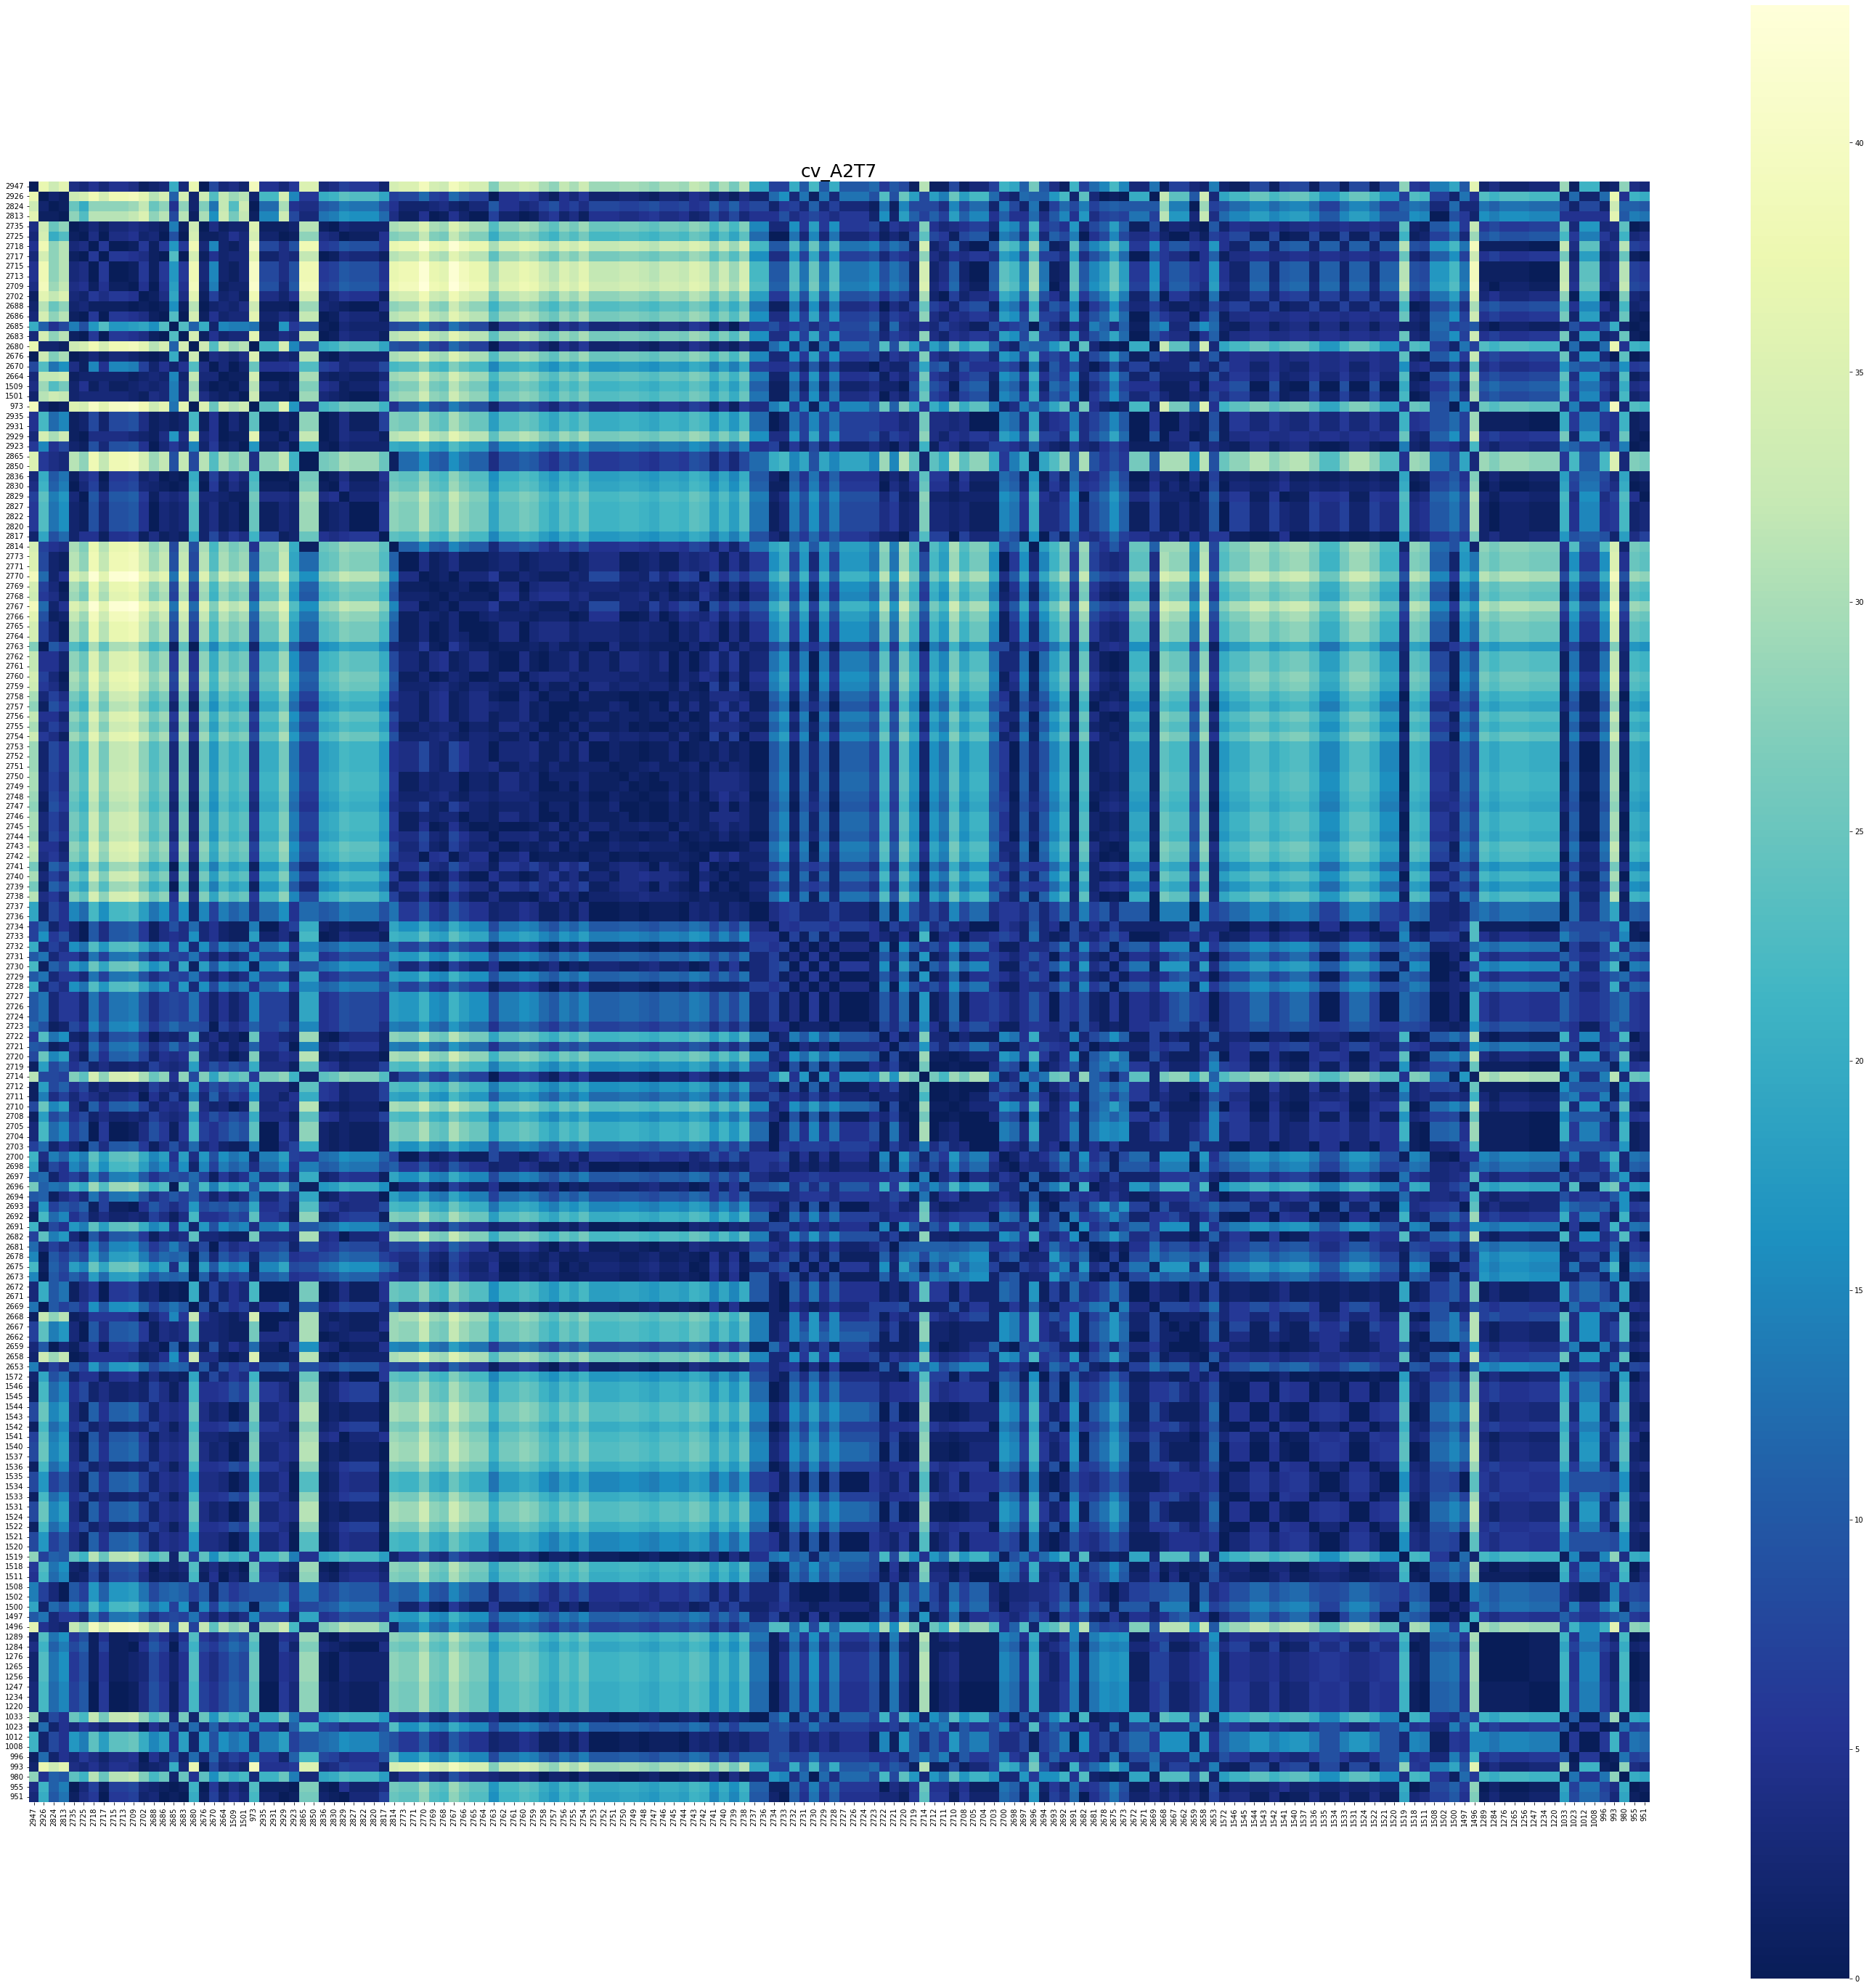

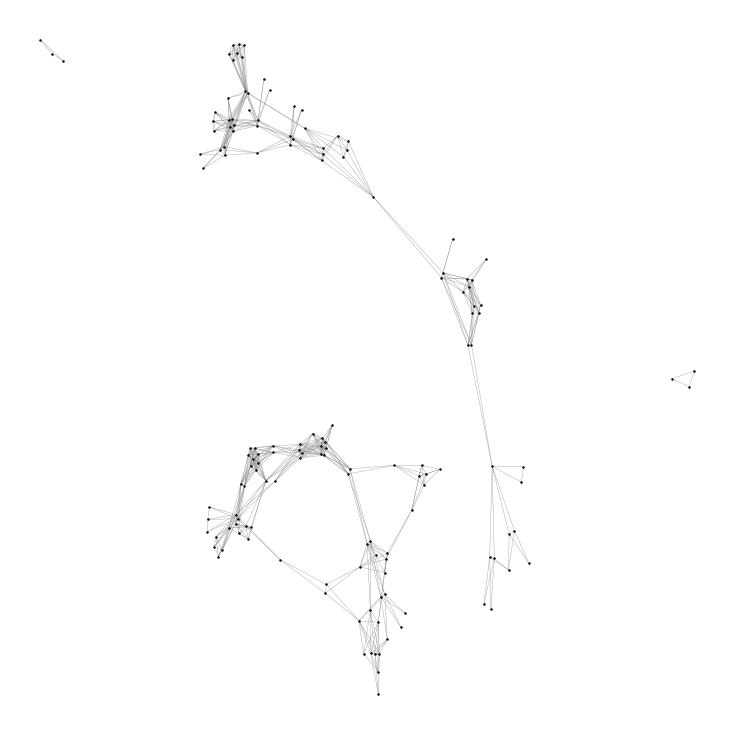

([68, 74, 3, 3], 4)

In [38]:
dist_A2T7_diff_dict = dist_diff(dist_cv_dict, dist_A2T7_dict, 'cv_A2T7')
diff_stat(dist_A2T7_diff_dict)
adj_structure(dist_A2T7_diff_dict)

655.0 146344.0


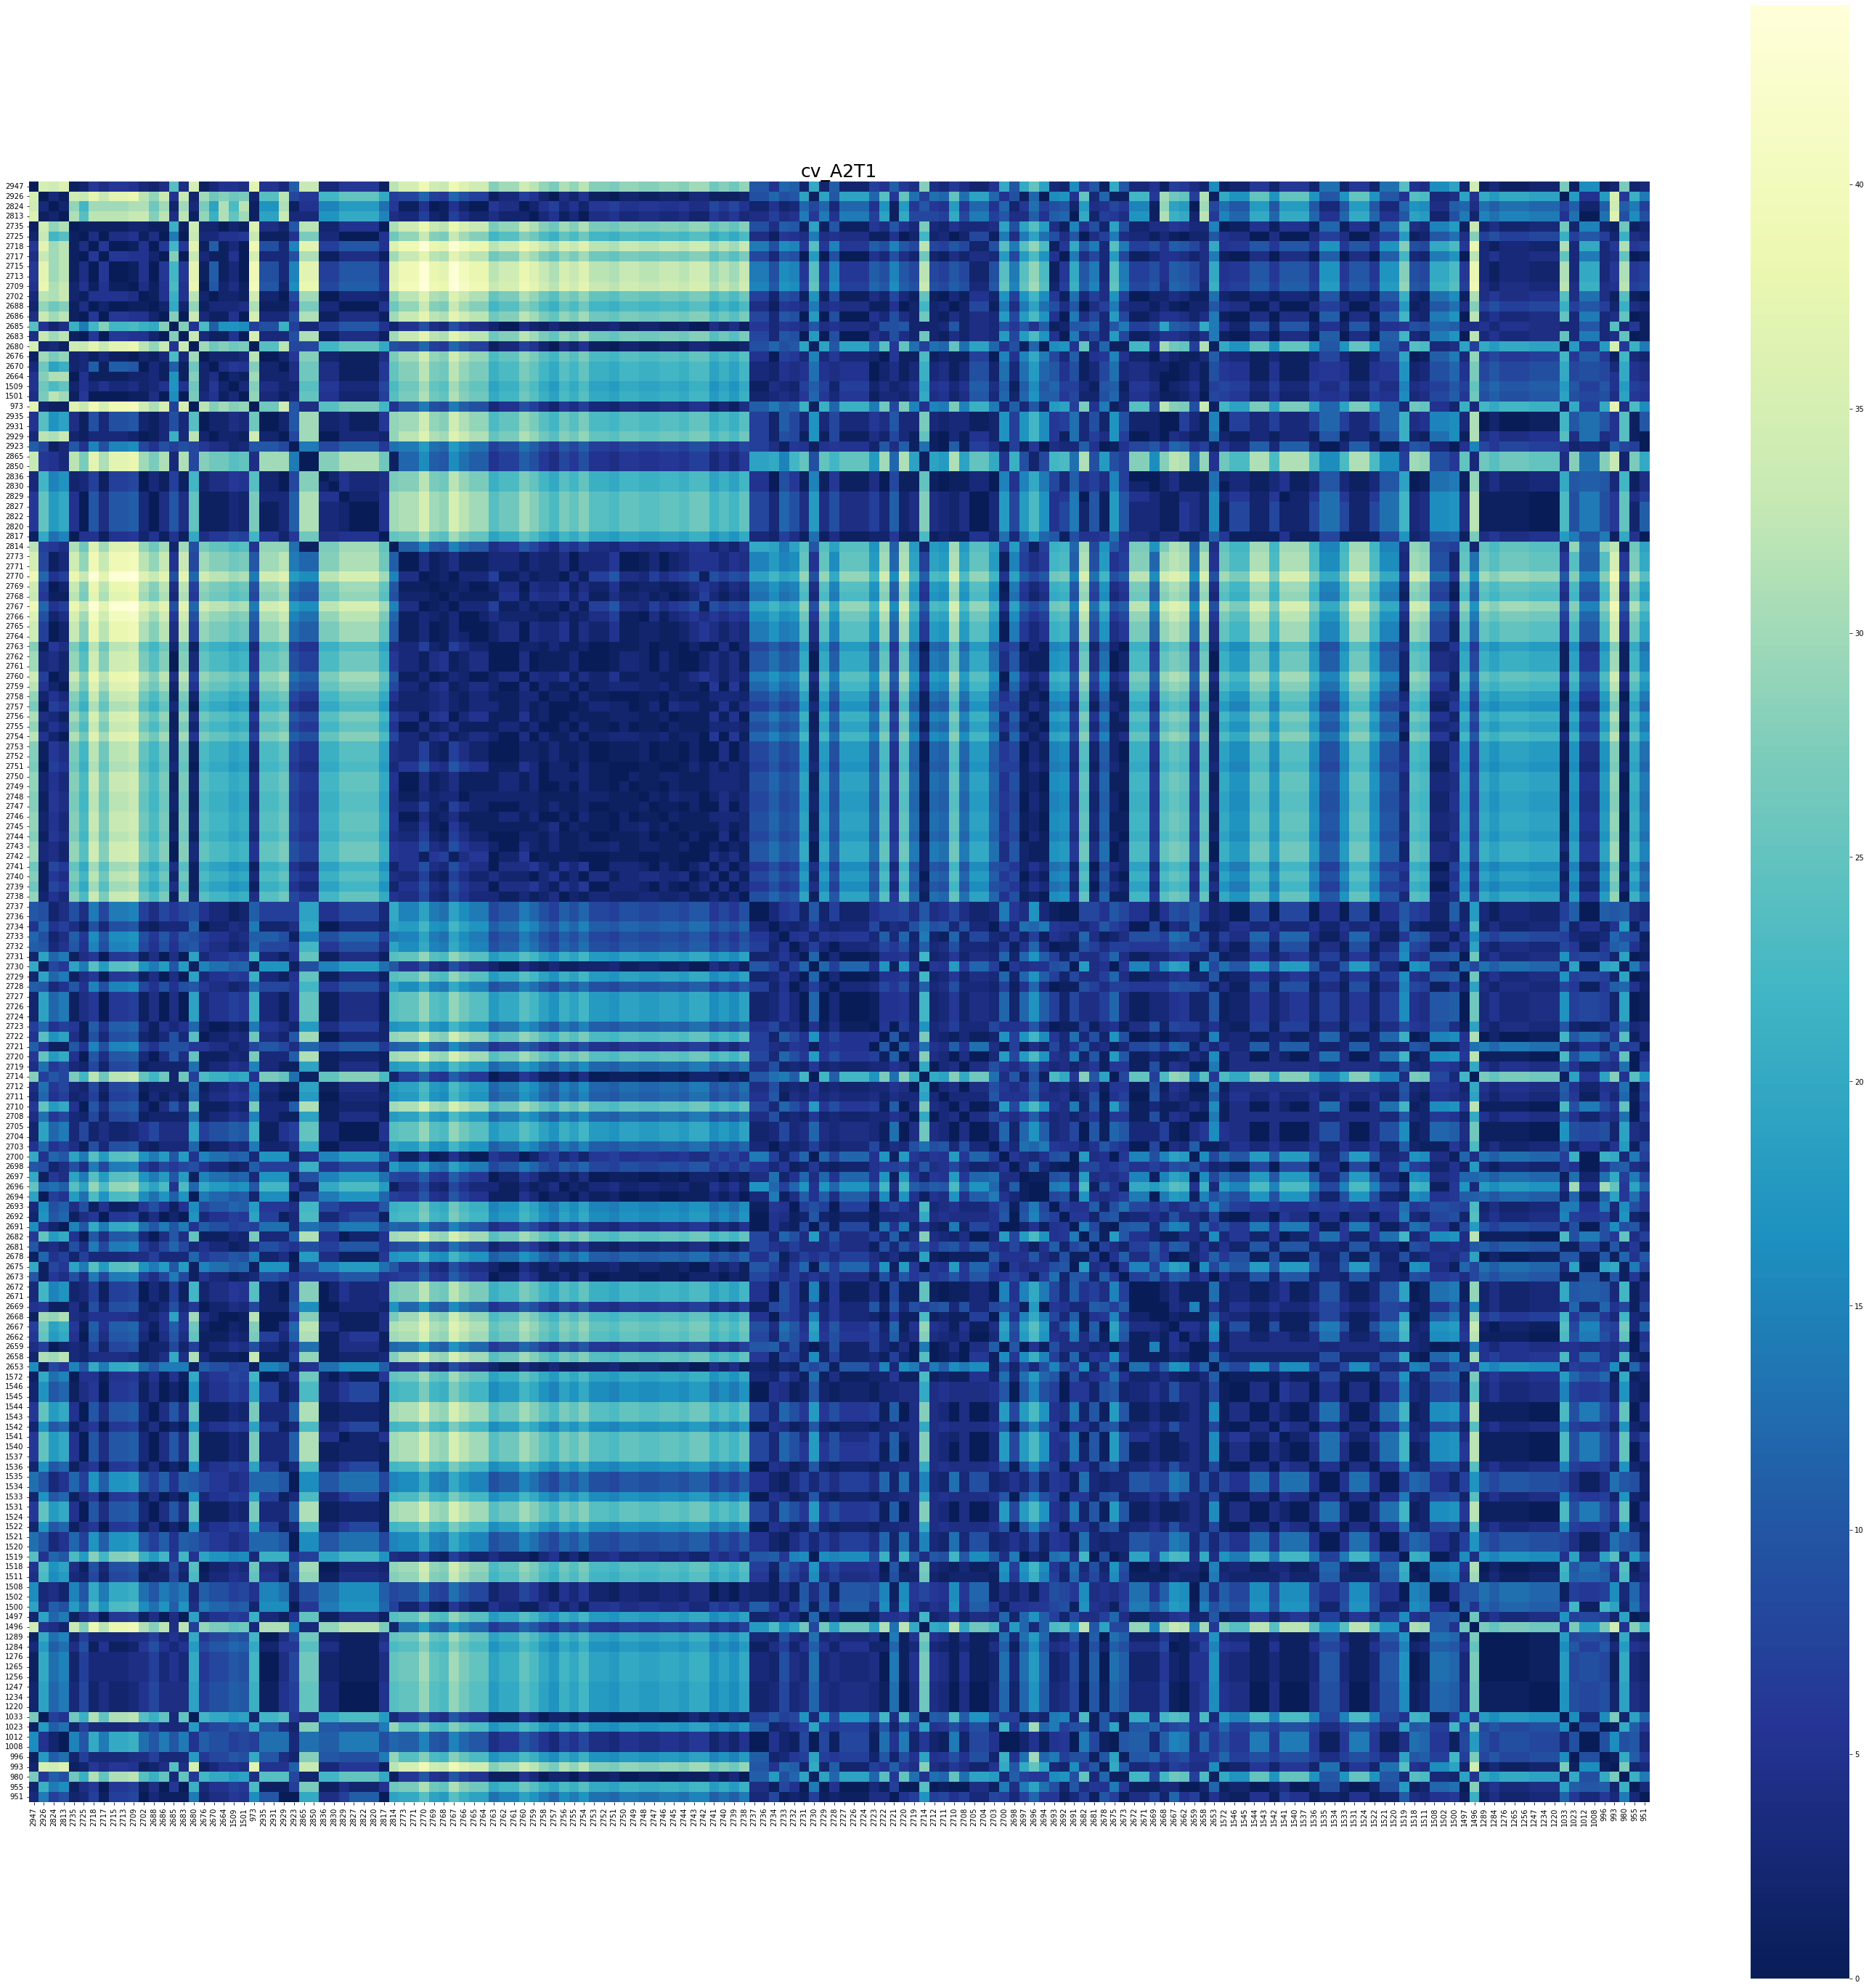

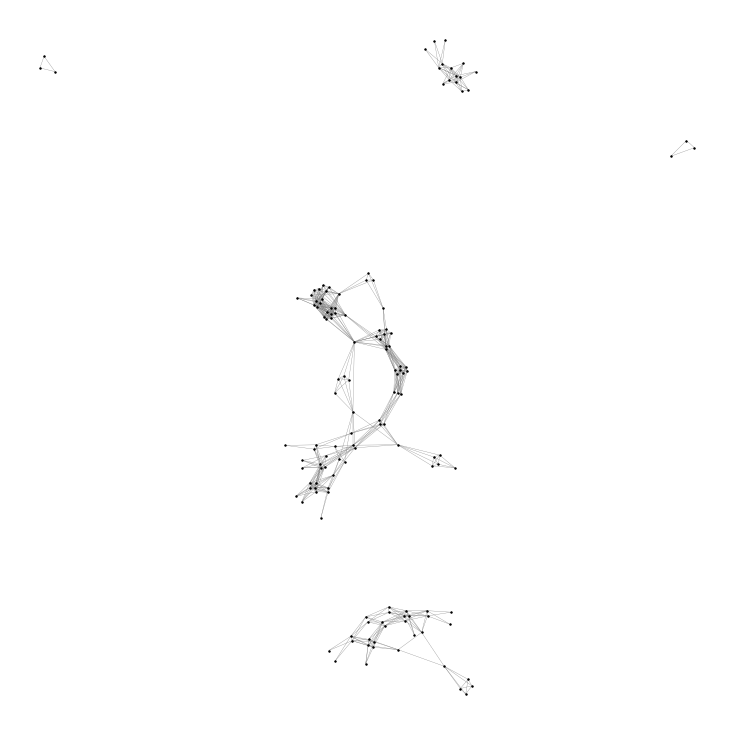

([31, 86, 15, 3, 3], 5)

In [39]:
dist_A2T1_diff_dict = dist_diff(dist_cv_dict, dist_A2T1_dict, 'cv_A2T1')
diff_stat(dist_A2T1_diff_dict)
adj_structure(dist_A2T1_diff_dict)

664.0 138795.0


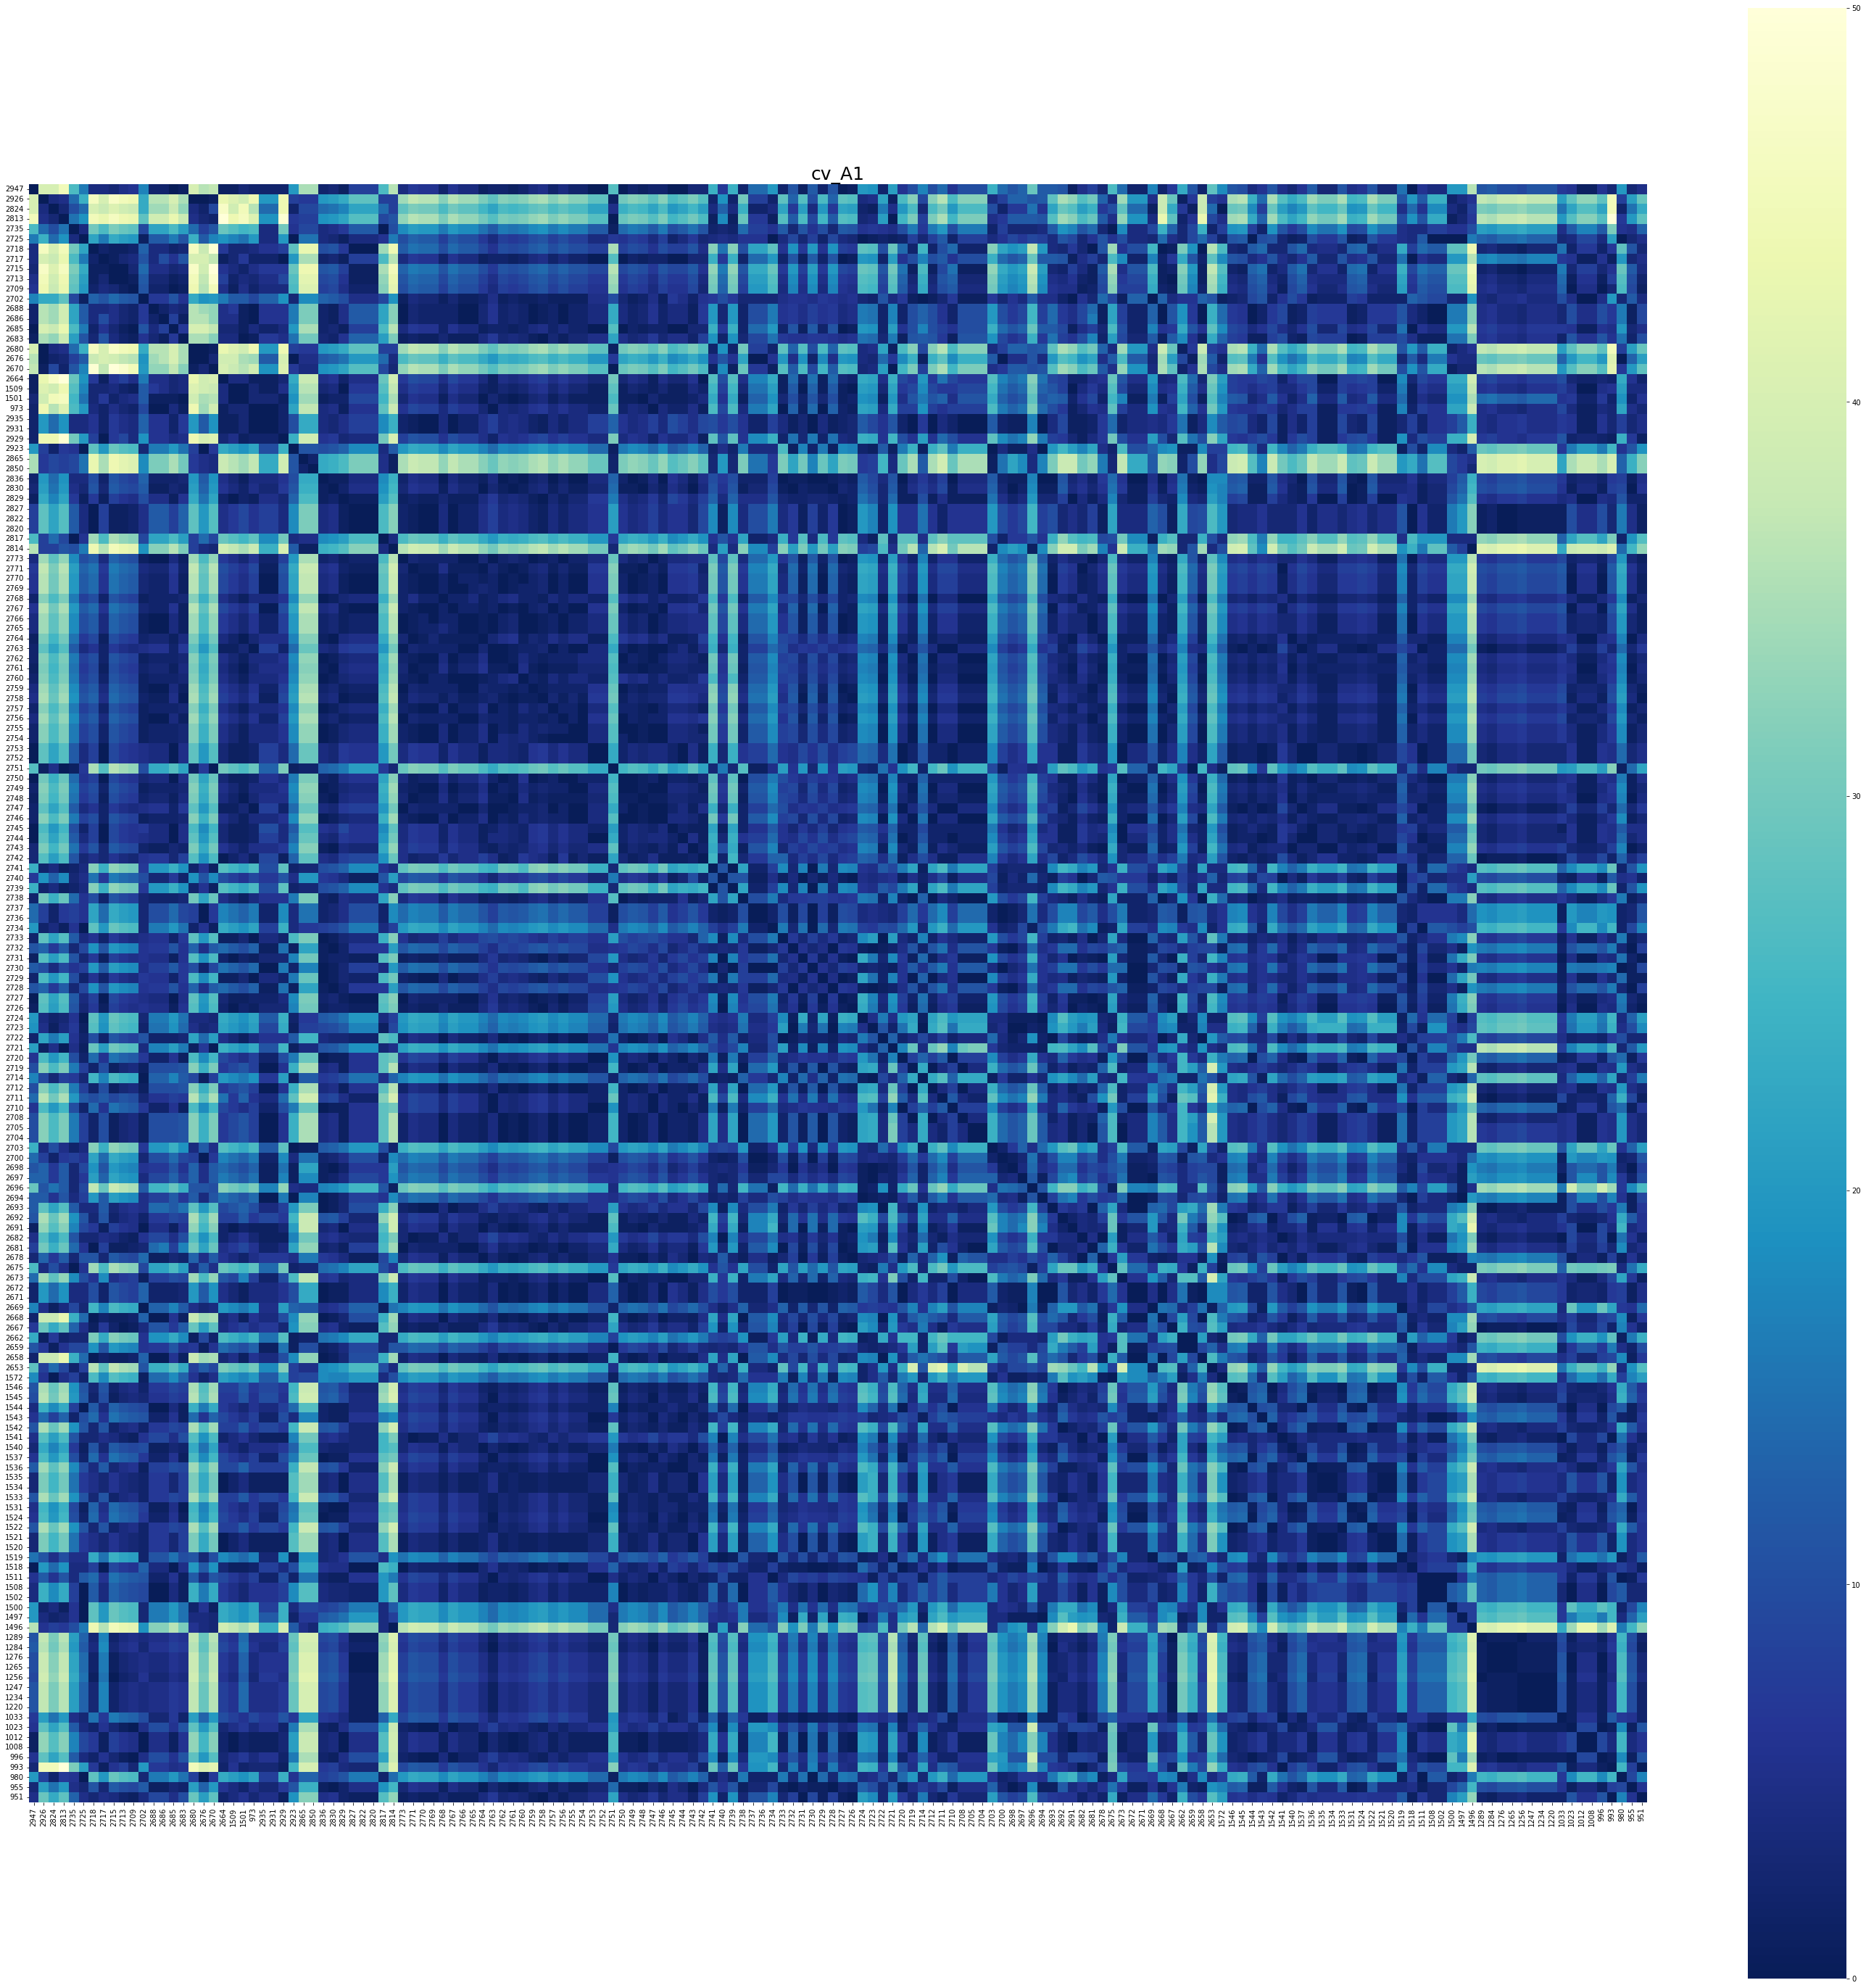

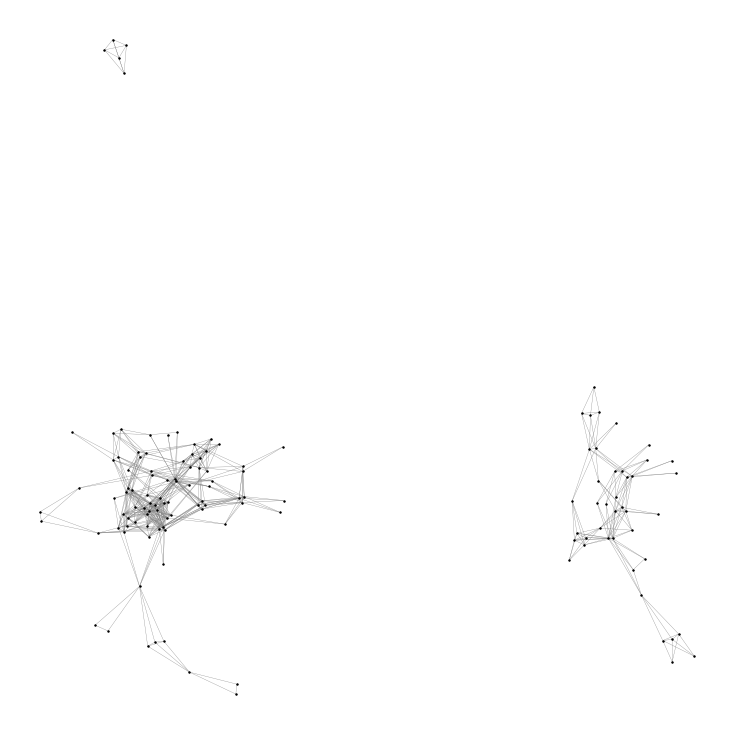

([85, 41, 5], 3)

In [40]:
dist_A1_diff_dict = dist_diff(dist_cv_dict, dist_A1_dict, 'cv_A1')
diff_stat(dist_A1_diff_dict)
adj_structure(dist_A1_diff_dict)

592.0 131814.0


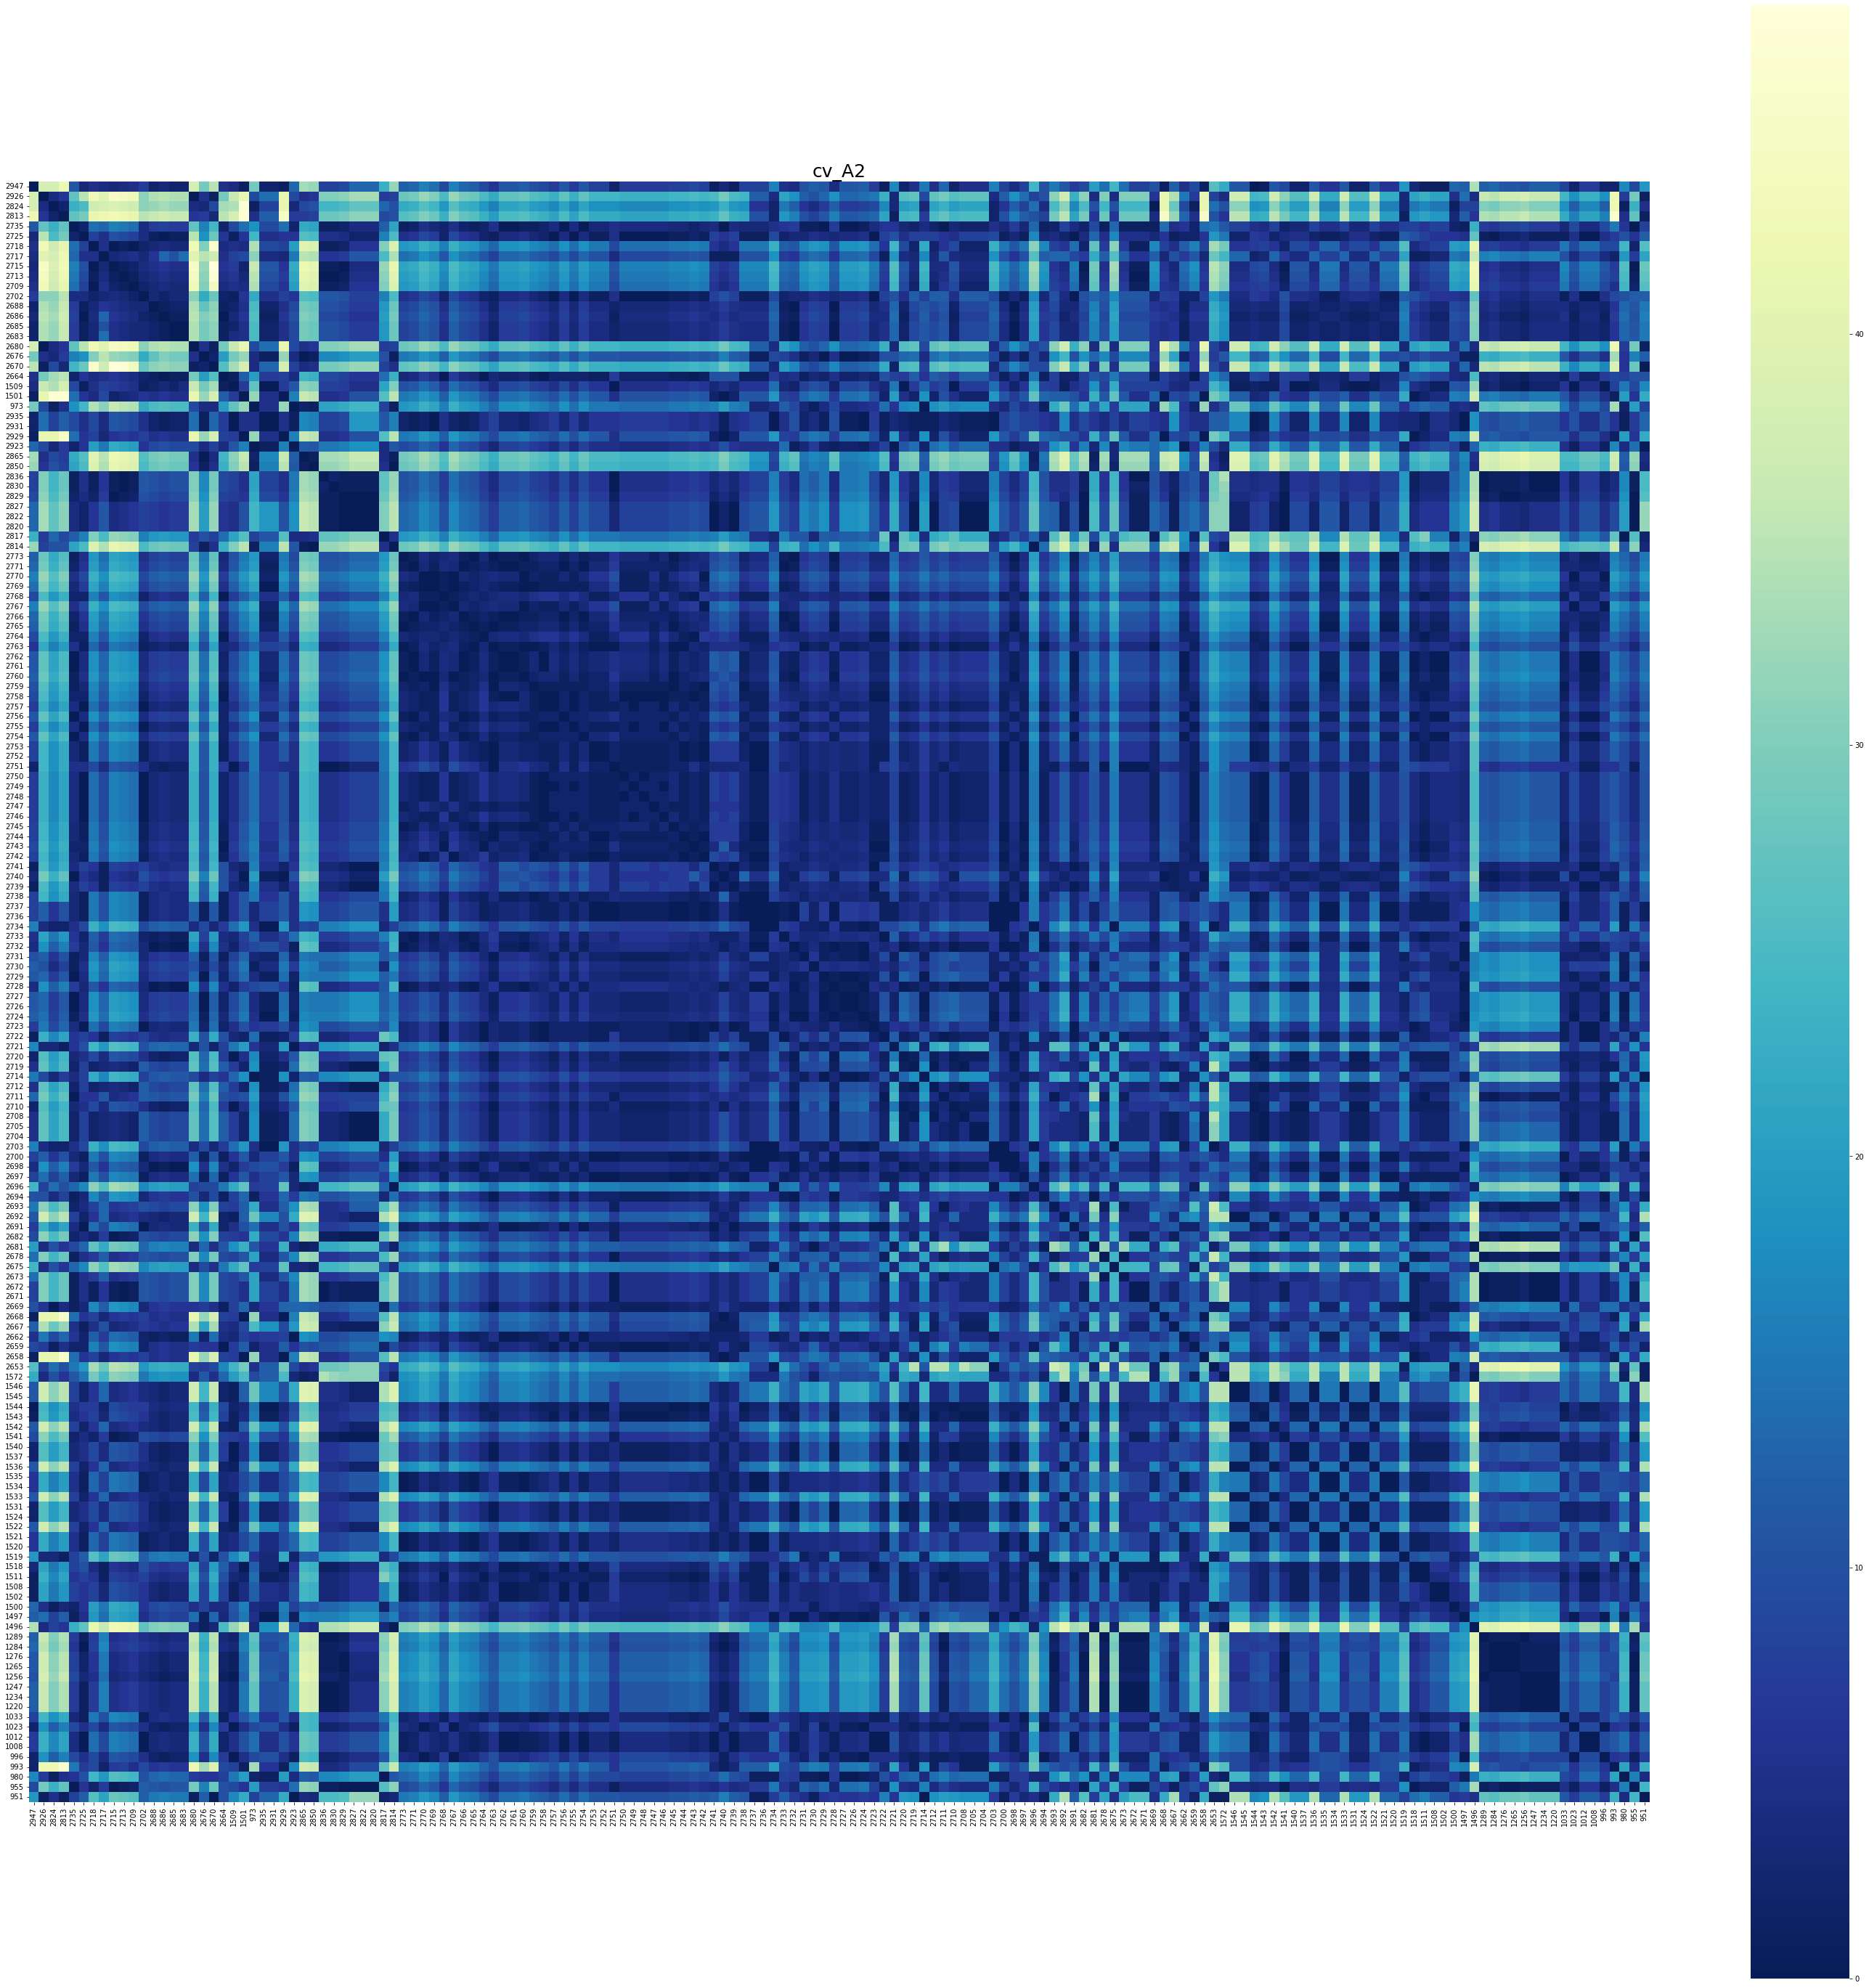

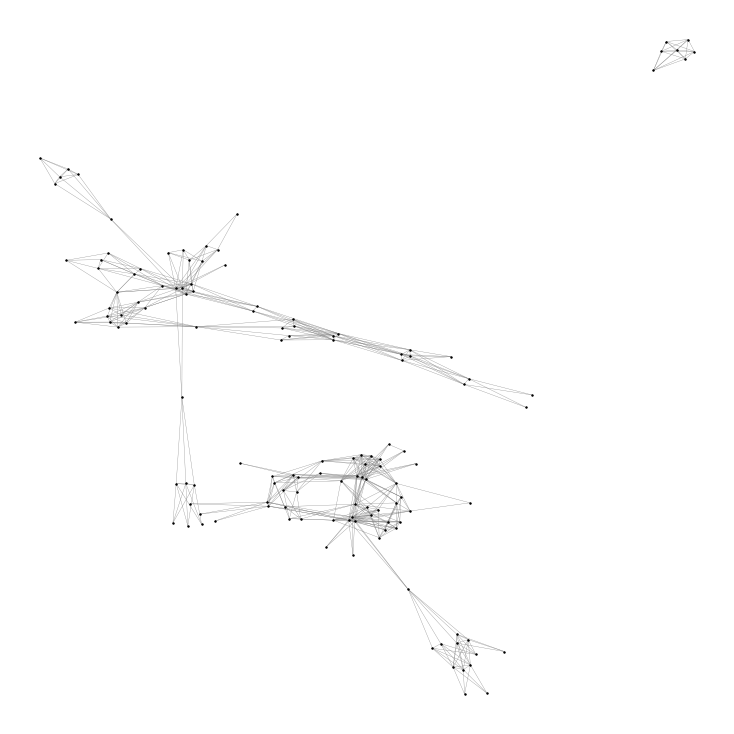

([63, 63, 7], 3)

In [41]:
dist_A2_diff_dict = dist_diff(dist_cv_dict, dist_A2_dict, 'cv_A2')
diff_stat(dist_A2_diff_dict)
adj_structure(dist_A2_diff_dict)

573.0 122544.0


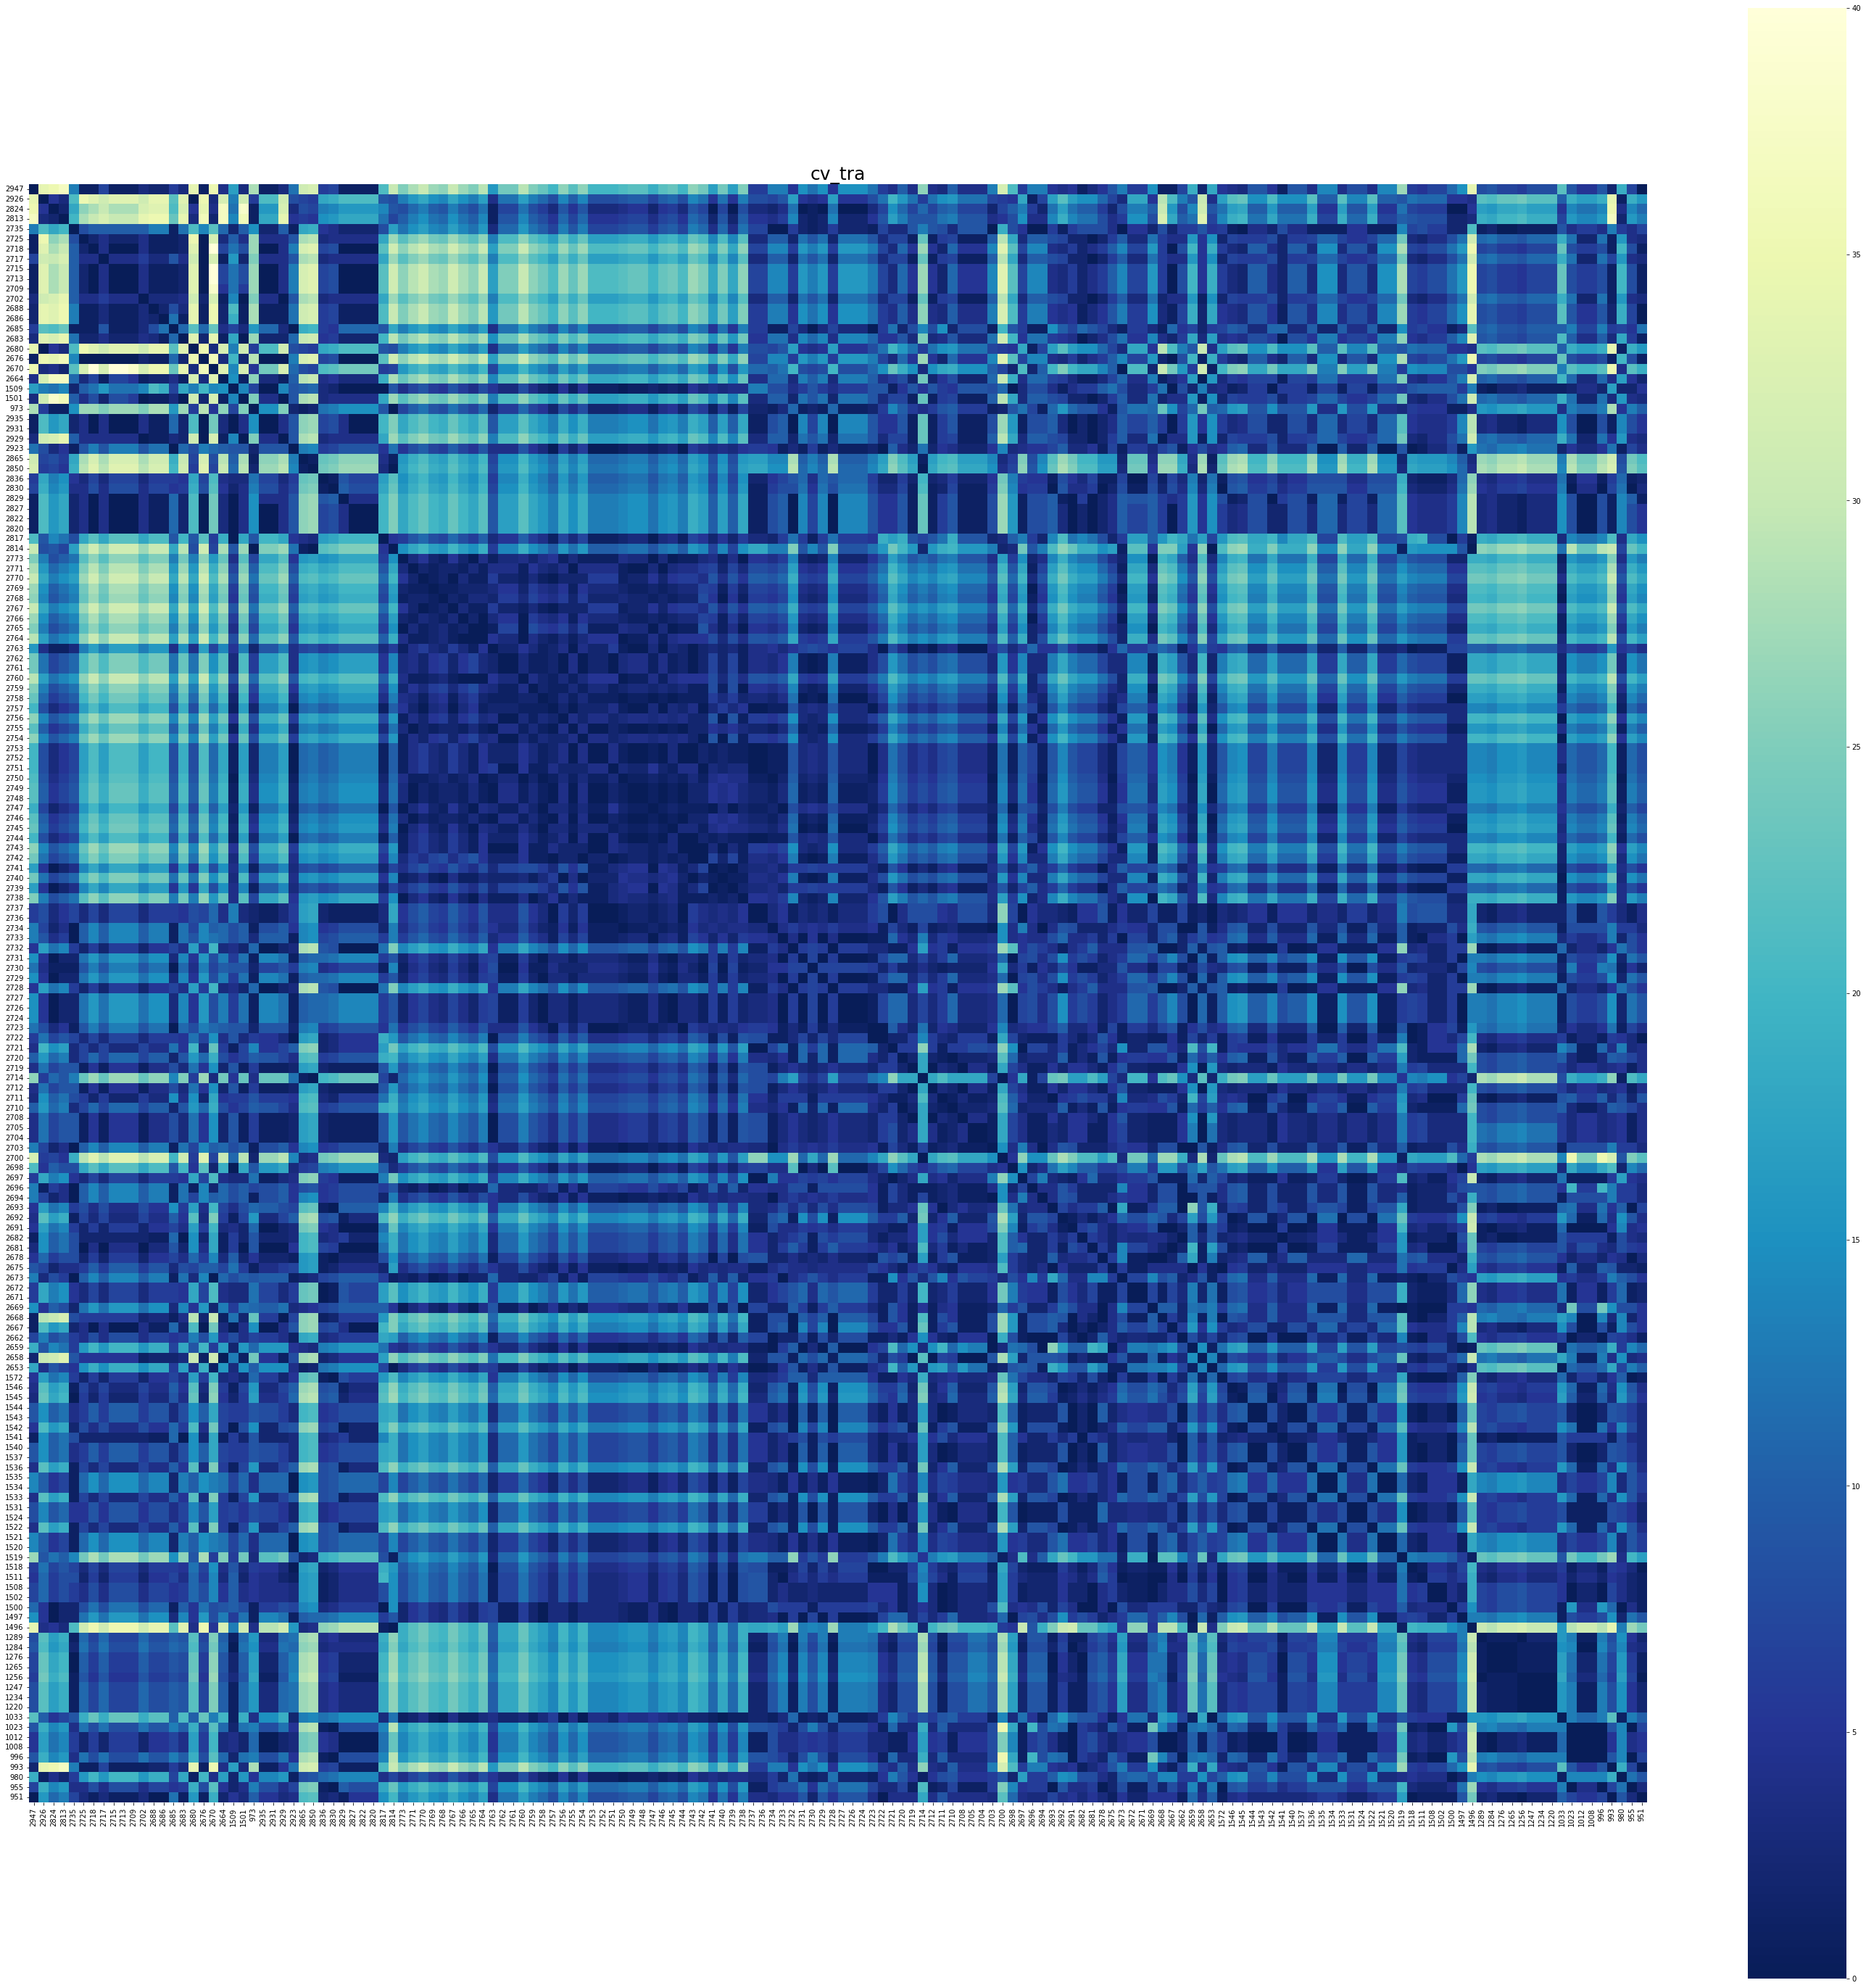

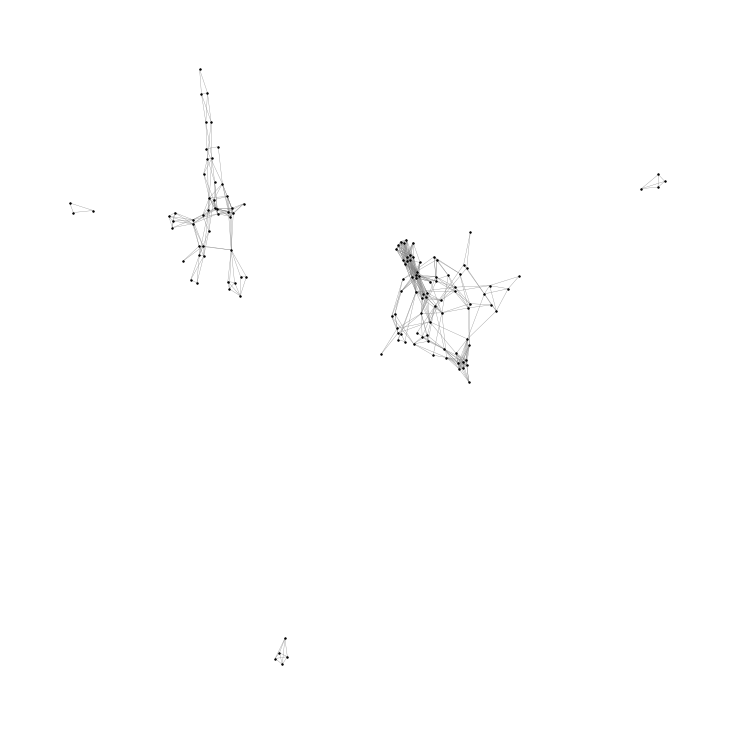

([77, 46, 3, 5, 4], 5)

In [40]:
dist_tra_dict = dist_diff(dist_cv_dict, dist_tra_dict, 'cv_tra')
diff_stat(dist_tra_dict)
adj_structure(dist_tra_dict)

413.0 180959.0


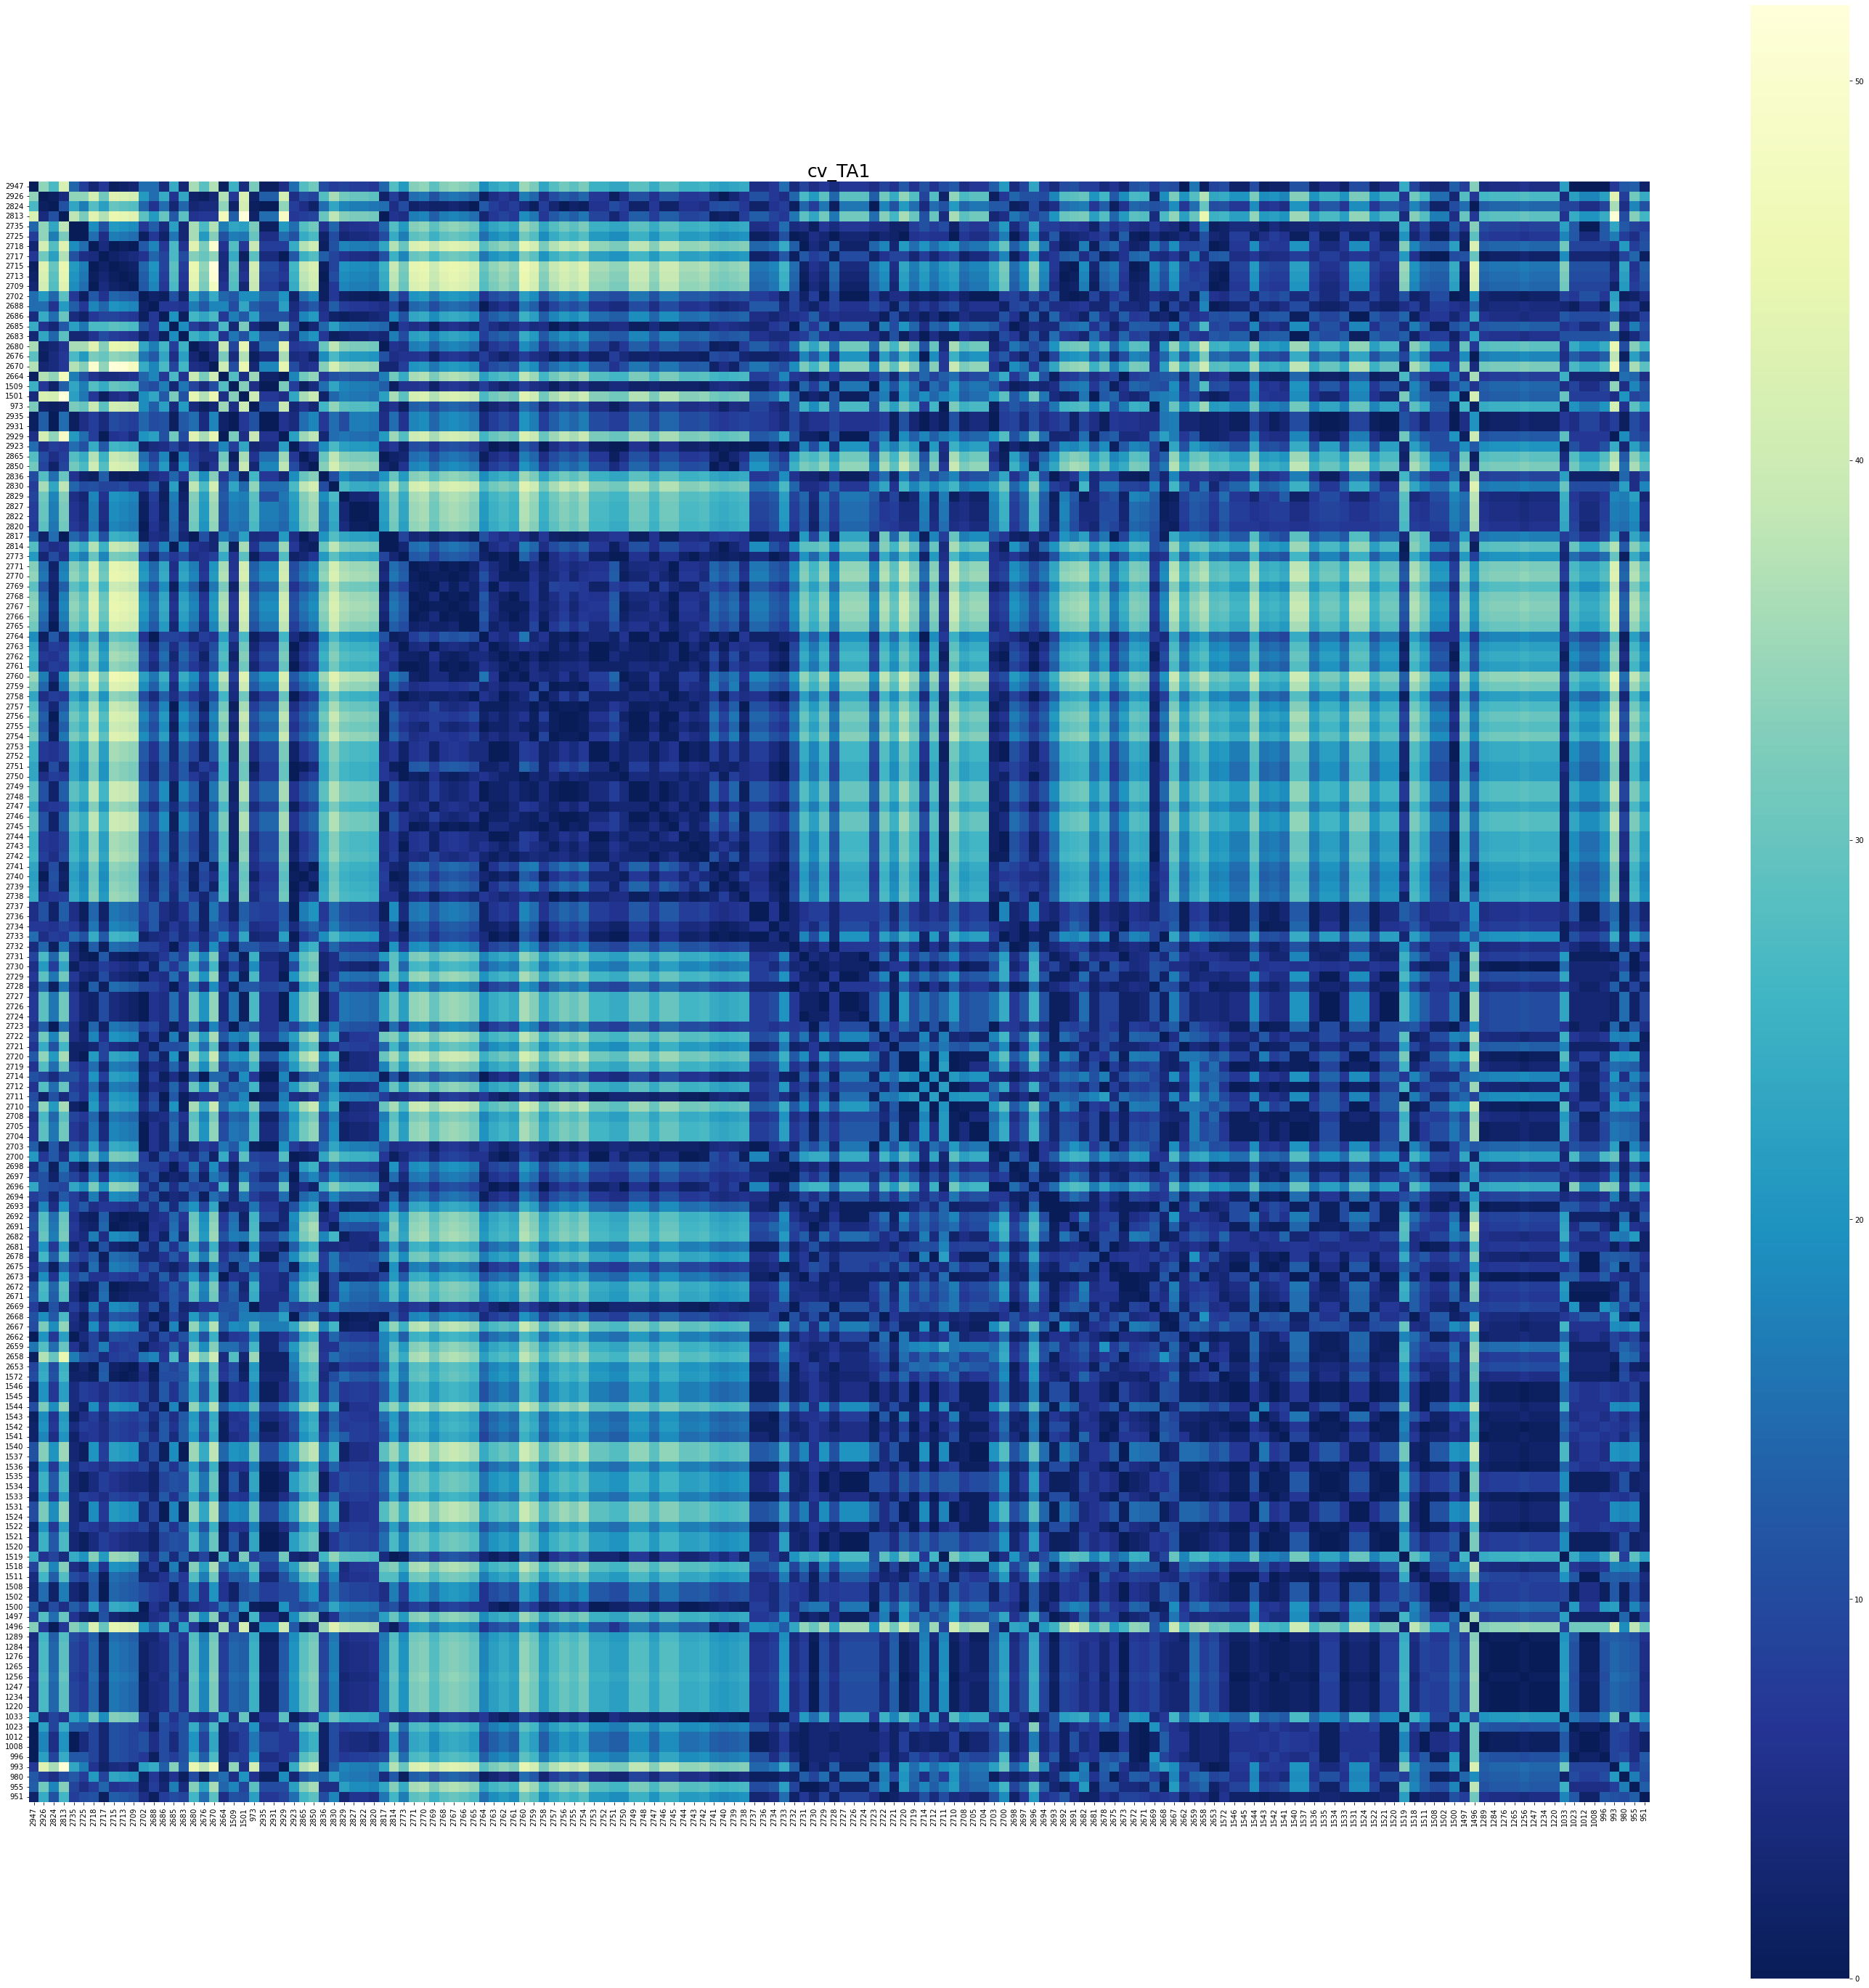

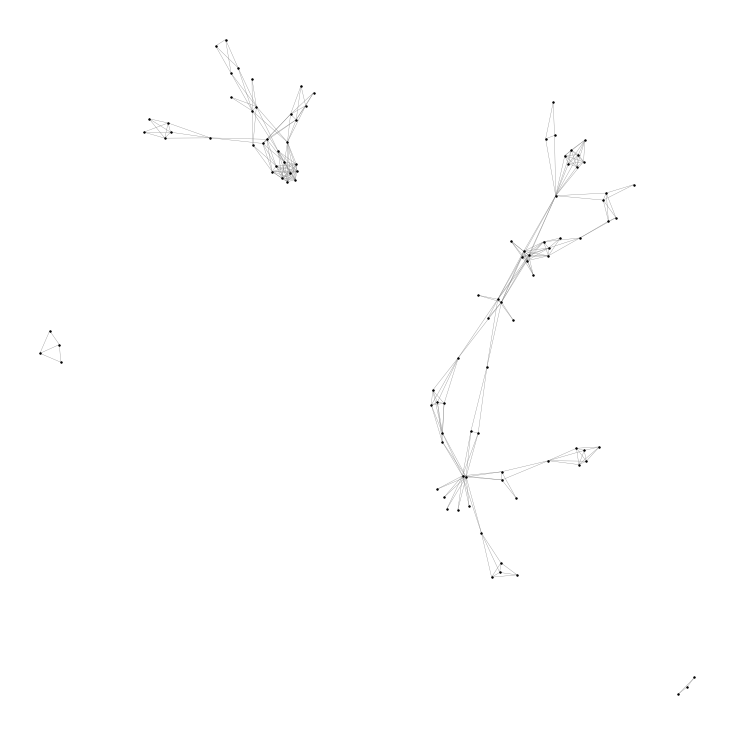

([33, 63, 3, 4], 4)

In [42]:
dist_TA1_diff_dict = dist_diff(dist_cv_dict, dist_TA1_dict, 'cv_TA1')
diff_stat(dist_TA1_diff_dict)
adj_structure(dist_TA1_diff_dict)

382.0 199373.0


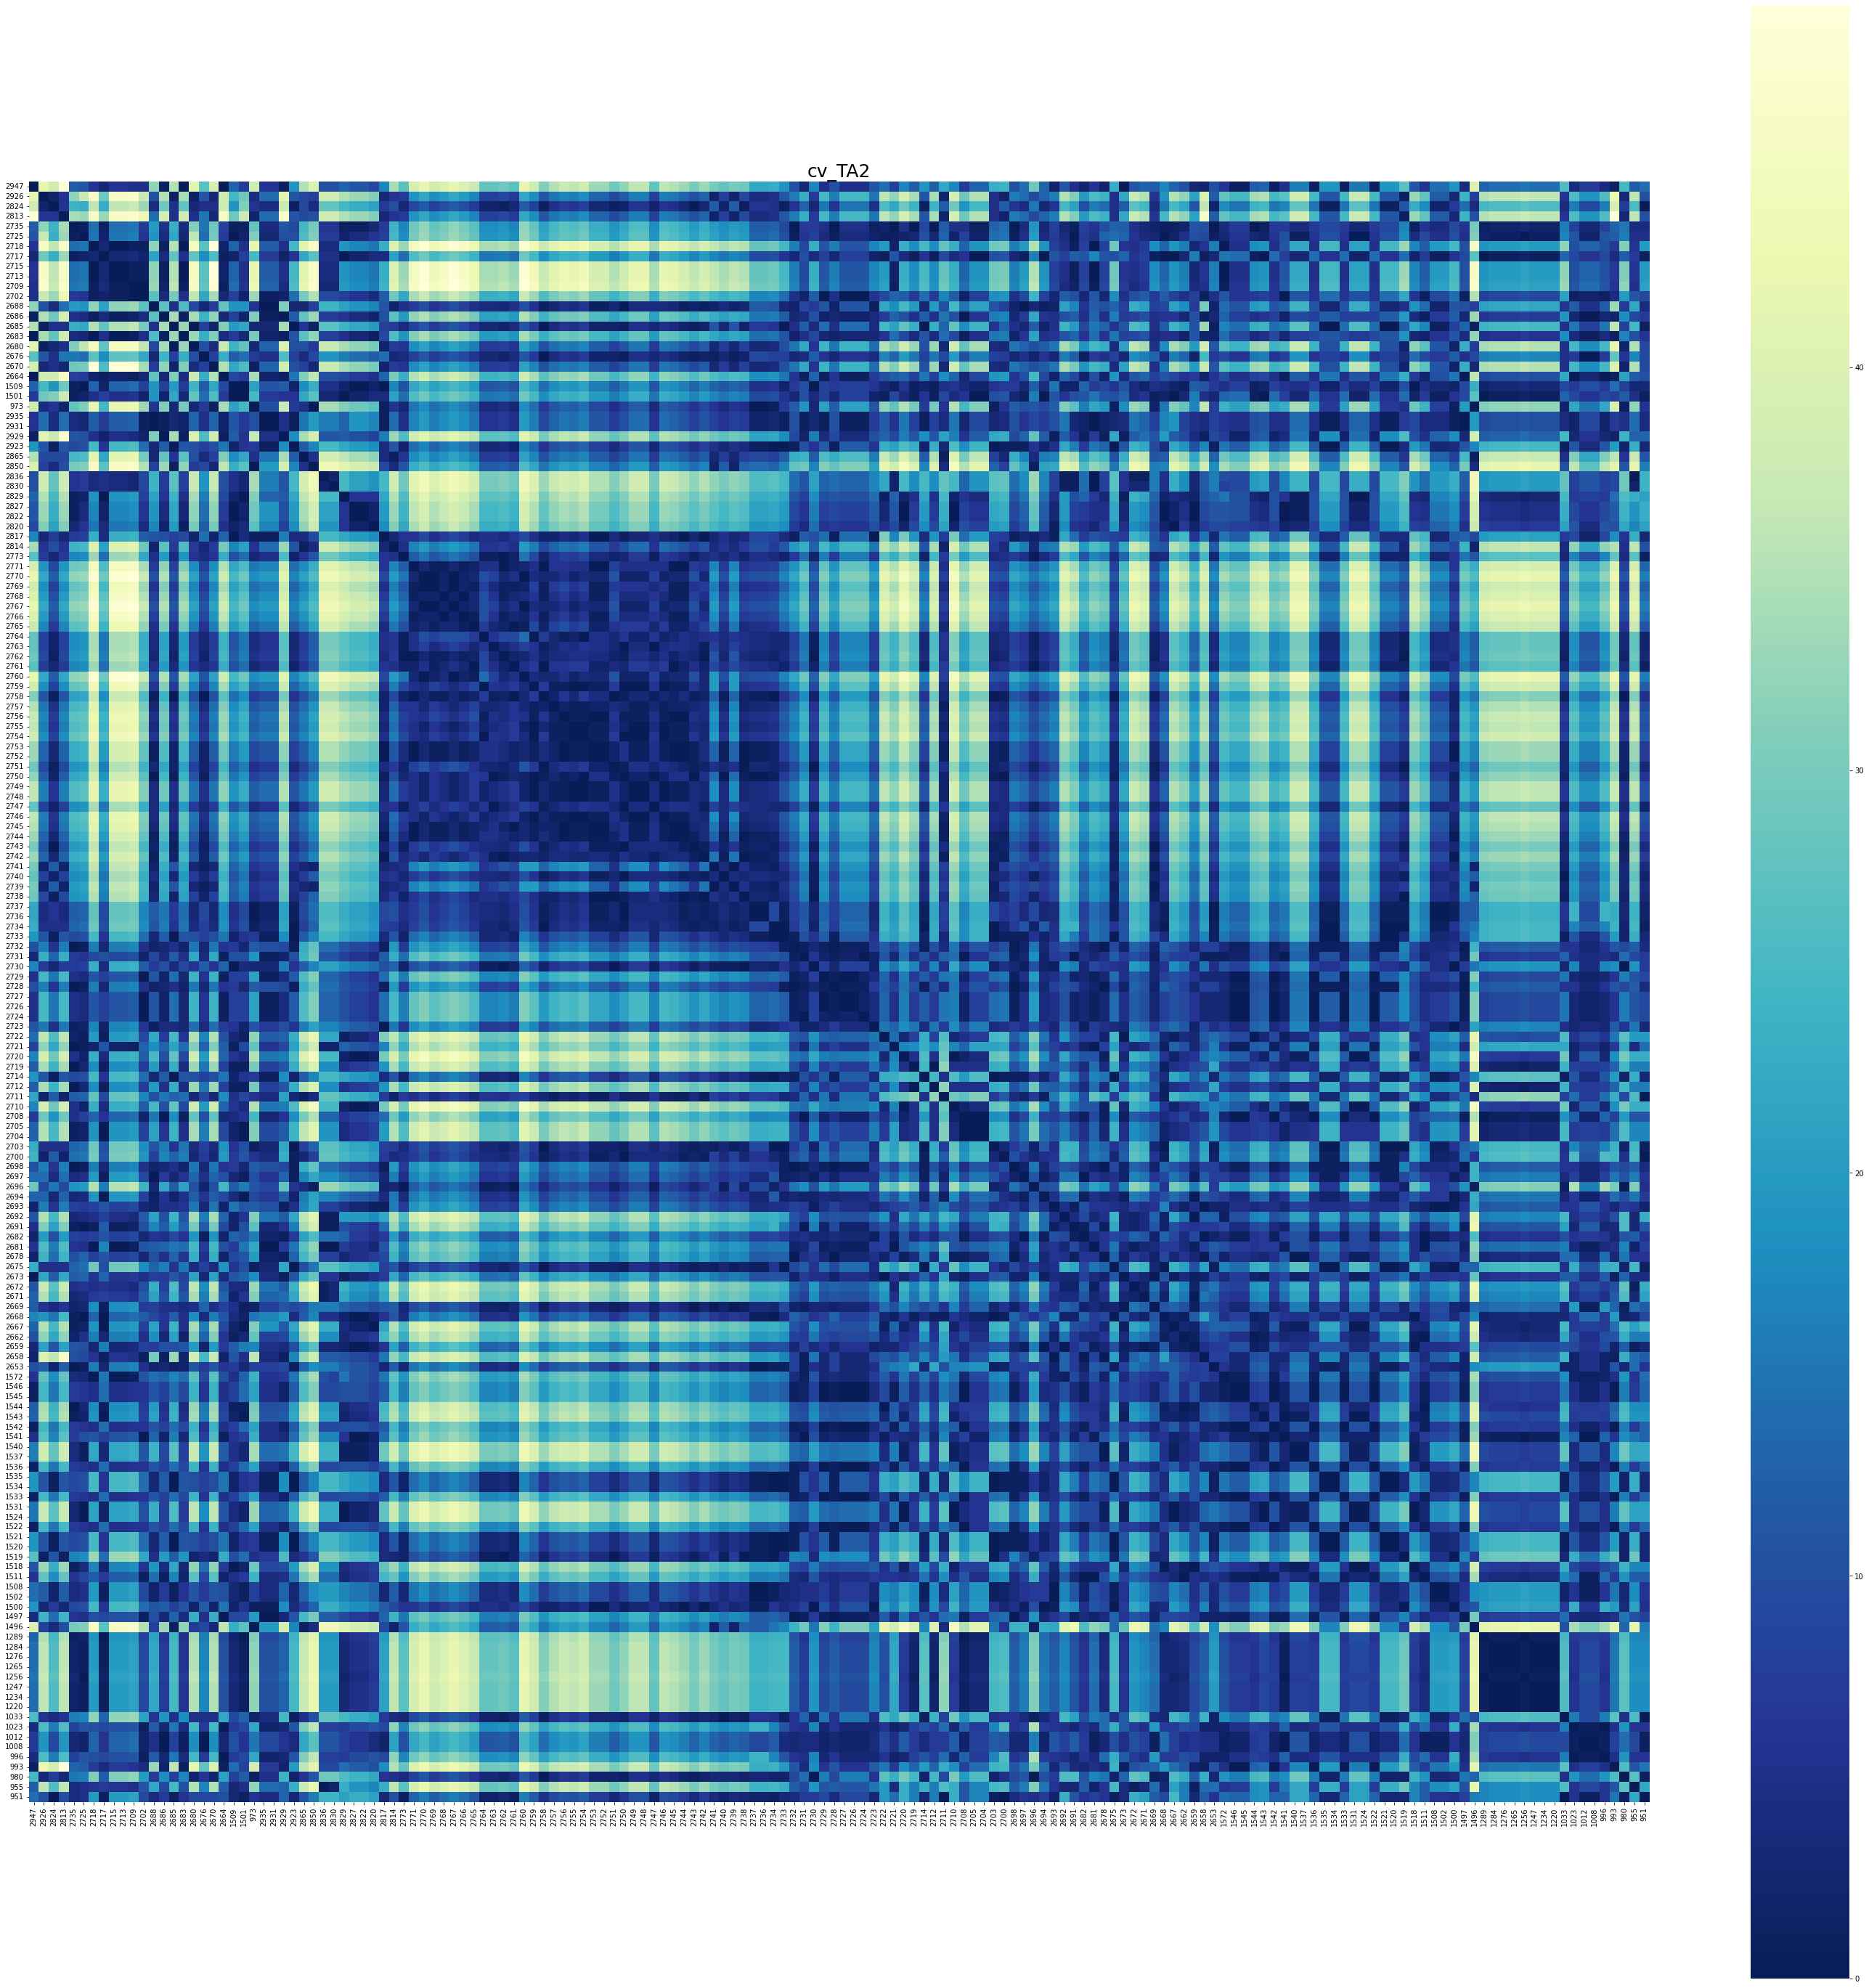

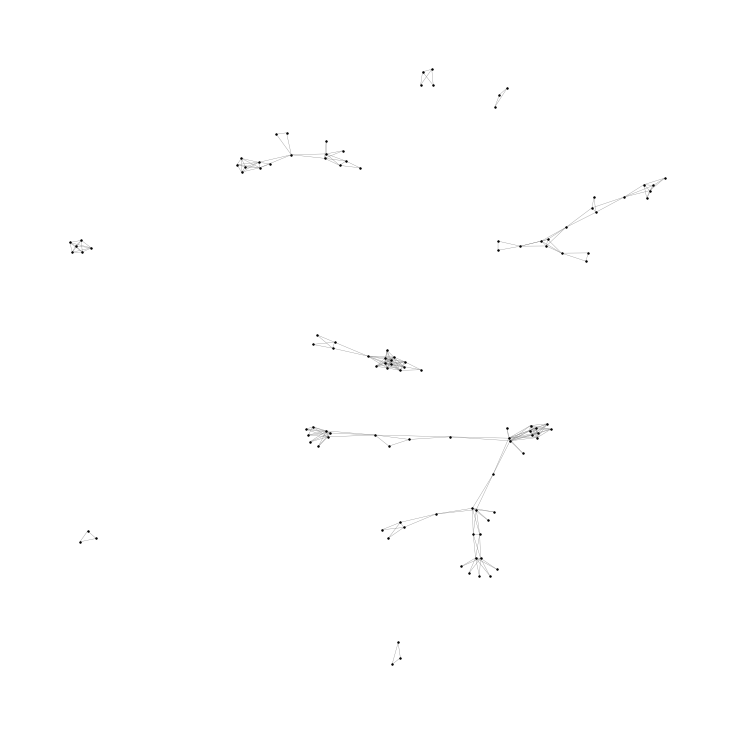

([19, 43, 4, 17, 3, 17, 3, 6, 3], 9)

In [42]:
dist_TA2_dict = dist_diff(dist_cv_dict, dist_TA2_dict, 'cv_TA2')
diff_stat(dist_TA2_dict)
adj_structure(dist_TA2_dict)